Cellranger relevant docs:
* https://support.10xgenomics.com/single-cell-vdj/software/pipelines/latest/output/overview
* https://support.10xgenomics.com/single-cell-vdj/software/pipelines/latest/output/annotation


In [95]:
import os
import fnmatch
import re
import pandas as pd

def find_substring_between_patterns(input_string, pattern1, pattern2):
    # Construct the regular expression pattern to find text between pattern1 and pattern2
    regex_pattern = re.escape(pattern1) + '(.*?)' + re.escape(pattern2)
    
    # Search for the pattern in the input string
    match = re.search(regex_pattern, input_string)
    
    # If a match is found, return the matched group (substring between patterns)
    if match:
        return match.group(1)
    else:
        return None

def process_tsv(dfi,name):
    # Initialize the new column in df2
    dfi['cell_line'] = None

    # Iterate over rows in df2
    for idx, row in dfi.iterrows():
        if row['cdr3'] in df1.CDR3aa.to_list():
            dfi.at[idx, 'cell_line'] = df1.set_index('CDR3aa').loc[row['cdr3'],'cell_line']
    
    total_cells = len(dfi.barcode.unique())

    print(f"[{name}]...")
    print(f"Total cells:{total_cells}")
    print("Cell line counts:")
    ### Define a dataframe containing one record per cell
    # Drop records where cell_line undefined first and sort so that IGH entries come first
    # Then drop duplicate barcodes. With keep='first', cells with both heavy and light chain entries will retain heavy chain entries.
    # This handles the situation where one chain has an exact reference CDR3nt match, but the other does not.
    # The result is a dataframe containing one record per cell, and only the record where cell_line is defined.
    # It also handles the situation where heavy and light chain cell_line determination disagree. Only the heavy chain entry will be retained if it exists.
    dfi_unique = dfi[~pd.isna(dfi['cell_line'])].sort_values(by='chain',ascending=True) 
    dfi_unique = dfi_unique[~dfi_unique.barcode.duplicated(keep='first')]
    
    print(f"dfi_unique: {dfi_unique.shape[0]}")
    print(dfi_unique.cell_line.value_counts(dropna=False))
    print("Clonotype counts:")
    #print(dfi.raw_clonotype_id.value_counts())
    print(dfi_unique[['cell_line','raw_clonotype_id']].value_counts(dropna=False))
    return dfi

def find_tsv_files(directory):            
    df_dict = {}
    
    for root, dirnames, filenames in os.walk(directory):
        for filename in fnmatch.filter(filenames, 'filtered_contig_annotations.csv'):
            file_path = os.path.join(root, filename)
        
            # Read the CSV file into a DataFrame
            df = pd.read_csv(file_path,header=0)#,index_col=0)
            #df_name = find_substring_between_patterns(file_path,'/home/miguelp95/projects/BCR-SEQC/data/10x/pfda_rerun/','/per_sample_outs/')
            df_name = find_substring_between_patterns(file_path,'/home/miguelp95/projects/BCR-SEQC/data/10x/5pVDJ_10xGenomics/','/per_sample_outs/')

            df = process_tsv(df,df_name)
            
            # Append the DataFrame to the dictionary
            df_dict[df_name] = df
    
    return df_dict


df1 = pd.read_csv('/home/miguelp95/projects/BCR-SEQC/reference_clonotypes.csv',header=0)#,index_col=0)

directory_to_search = '/home/miguelp95/projects/BCR-SEQC/data/10x/5pVDJ_10xGenomics' # 10X results: 5pVDJ_10xGenomics; pFDA results: pfda_rerun
df_dict = find_tsv_files(directory_to_search)


[5_v2_Bcellsort_Rep1]...
Total cells:8114
Cell line counts:
dfi_unique: 112
cell_line
JK-6        82
WSU-DLCL    30
Name: count, dtype: int64
Clonotype counts:
cell_line  raw_clonotype_id
JK-6       clonotype7          3
           clonotype4          3
           clonotype7026       1
WSU-DLCL   clonotype1060       1
           clonotype1055       1
                              ..
JK-6       clonotype3856       1
           clonotype3854       1
           clonotype3853       1
           clonotype3852       1
WSU-DLCL   clonotype828        1
Name: count, Length: 108, dtype: int64
[5_v2_Bcellsort_Rep2]...
Total cells:7939
Cell line counts:
dfi_unique: 56
cell_line
WSU-DLCL    28
JK-6        24
MEC-1        2
RI-1         1
WSU-NHL      1
Name: count, dtype: int64
Clonotype counts:
cell_line  raw_clonotype_id
JK-6       clonotype1228       1
           clonotype1239       1
WSU-DLCL   clonotype2456       1
           clonotype2471       1
           clonotype2472       1
           cl

In [23]:
df = df_dict['5pv2_MMC_Rep1']
df

,barcode,is_cell,contig_id,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,...,cdr3,cdr3_nt,fwr4,fwr4_nt,reads,umis,raw_clonotype_id,raw_consensus_id,exact_subclonotype_id,cell_line
0,AAACCTGAGATAGCAT-1,True,AAACCTGAGATAGCAT-1_contig_1,True,551,IGK,IGKV1-33,NaN,IGKJ2,IGKC,...,CQQYDGLPRTF,TGTCAACAATATGACGGTCTTCCTCGGACTTTT,GQGTKLDIK,GGCCAGGGGACCAAACTGGACATCAAAC,1298,216,clonotype5,clonotype5_consensus_2,46,EHEB
1,AAACCTGAGATGGCGT-1,True,AAACCTGAGATGGCGT-1_contig_1,True,563,IGK,IGKV2-28,NaN,IGKJ4,IGKC,...,CMQALQTPLTF,TGCATGCAGGCTCTACAAACTCCTCTCACTTTC,GGGTKVDIK,GGCGGAGGGACCAAGGTGGACATCAAAC,4683,797,clonotype4,clonotype4_consensus_2,1,JK-6
2,AAACCTGAGATGGCGT-1,True,AAACCTGAGATGGCGT-1_contig_2,True,685,IGH,IGHV1-2,NaN,IGHJ3,IGHG1,...,CARWGSPSSPGIAAADDAFDIW,TGTGCGCGATGGGGCTCCCCTTCAAGCCCGGGTATAGCAGCAGCTG...,GQGTMVIVSS,GGCCAAGGGACAATGGTCATCGTCTCTTCAG,1563,319,clonotype4,clonotype4_consensus_1,1,JK-6
3,AAACCTGAGGGCTTGA-1,True,AAACCTGAGGGCTTGA-1_contig_1,True,591,IGK,IGKV1D-39,NaN,IGKJ4,IGKC,...,CQQNYNFSFTF,TGTCAACAGAATTACAATTTCTCGTTCACTTTC,GGGTKVDNK,GGCGGAGGGACCAAGGTGGACAACAAAC,1026,170,clonotype1,clonotype1_consensus_2,1,DAUDI
4,AAACCTGAGGGCTTGA-1,True,AAACCTGAGGGCTTGA-1_contig_2,True,551,IGH,IGHV3-74,NaN,IGHJ4,IGHM,...,CVRGNGQKCFDYW,TGTGTAAGAGGAAATGGTCAAAAATGTTTTGATTACTGG,GQGTLVTVSS,GGTCAGGGAACCCTGGTCACCGTCTCCTCAG,883,139,clonotype1,clonotype1_consensus_1,1,DAUDI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15144,TTTGTCATCCGGGTGT-1,True,TTTGTCATCCGGGTGT-1_contig_2,True,577,IGH,IGHV3-7,NaN,IGHJ4,IGHM,...,CARKCTPERGKLGFFDYW,TGTGCGAGAAAATGCACCCCCGAACGCGGCAAGTTAGGATTCTTTG...,GQGILVTVSS,GGCCAGGGAATCCTGGTCACCGTCTCCTCAG,1175,180,clonotype3,clonotype3_consensus_1,1,RI-1
15145,TTTGTCATCGAACGGA-1,True,TTTGTCATCGAACGGA-1_contig_1,True,577,IGH,IGHV3-7,NaN,IGHJ4,IGHM,...,CARKCTPERGKLGFFDYW,TGTGCGAGAAAATGCACCCCCGAACGCGGCAAGTTAGGATTCTTTG...,GQGILVTVSS,GGCCAGGGAATCCTGGTCACCGTCTCCTCAG,595,93,clonotype3,clonotype3_consensus_1,1,RI-1
15146,TTTGTCATCGAACGGA-1,True,TTTGTCATCGAACGGA-1_contig_2,True,633,IGK,IGKV4-1,NaN,IGKJ2,IGKC,...,CQQYYSVPYTF,TGTCAGCAATATTATAGTGTTCCGTACACTTTT,GQGTKLEIK,GGCCAGGGGACCAAGCTGGAAATCAAAC,1248,206,clonotype3,clonotype3_consensus_2,1,RI-1
15147,TTTGTCATCGCACTCT-1,True,TTTGTCATCGCACTCT-1_contig_1,True,553,IGK,IGKV1D-39,NaN,IGKJ4,IGKC,...,CQQNYNFSFTF,TGTCAACAGAATTACAATTTCTCGTTCACTTTC,GGGTKVDNK,GGCGGAGGGACCAAGGTGGACAACAAAC,1168,205,clonotype1,clonotype1_consensus_2,1,DAUDI


In [96]:
for sample_name, df in df_dict.items():
    reads = df.reads.sum()
    umis = df.umis.sum()
    cells = len(df.barcode.unique())
    reads_per_cell = reads / cells
    umis_per_cell = umis / cells
    print(f"[{sample_name}]: \n")
    print(f"...{reads} reads\n")
    print(f"...{cells} cells\n")
    print(f"...{round(reads_per_cell,1)} reads per cell\n")
    print(f"...{round(umis_per_cell,1)} UMIs per cell\n")

[5_v2_Bcellsort_Rep1]: 

...18838048 reads

...8114 cells

...2321.7 reads per cell

...78.7 UMIs per cell

[5_v2_Bcellsort_Rep2]: 

...26834935 reads

...7939 cells

...3380.1 reads per cell

...62.3 UMIs per cell

[5_v2_Bcellsort_Rep3]: 

...25812626 reads

...7661 cells

...3369.4 reads per cell

...64.2 UMIs per cell

[5_v2_MMC_10_Rep1]: 

...33252141 reads

...8656 cells

...3841.5 reads per cell

...127.6 UMIs per cell

[5_v2_MMC_10_Rep2]: 

...29370902 reads

...7933 cells

...3702.4 reads per cell

...128.7 UMIs per cell

[5_v2_MMC_10_Rep3]: 

...31043395 reads

...7819 cells

...3970.3 reads per cell

...115.5 UMIs per cell

[5_v2_MMC_1_Rep1]: 

...26691791 reads

...8167 cells

...3268.2 reads per cell

...60.5 UMIs per cell

[5_v2_MMC_1_Rep3]: 

...18492413 reads

...7349 cells

...2516.3 reads per cell

...72.3 UMIs per cell

[5_v2_MMC_Rep1]: 

...31192708 reads

...7881 cells

...3958.0 reads per cell

...709.2 UMIs per cell

[5_v2_MMC_Rep2]: 

...36243834 reads

...7132 c

In [99]:
sample = 'Bcellsort'

df1 = df_dict[f'5_v2_{sample}_Rep1']
df2 = df_dict[f'5_v2_{sample}_Rep2']
df3 = df_dict[f'5_v2_{sample}_Rep3']

## ALL CLONOTYPES
print("---ALL CLONOTYPES---")

# Split each library into heavy and light chain dataframes
df1_heavy = df1[df1['chain']=='IGH']
df1_light = df1[(df1['chain']=='IGK') | (df1['chain']=='IGL')]

df2_heavy = df2[df2['chain']=='IGH']
df2_light = df2[(df2['chain']=='IGK') | (df2['chain']=='IGL')]

df3_heavy = df3[df3['chain']=='IGH']
df3_light = df3[(df3['chain']=='IGK') | (df3['chain']=='IGL')]

print(f"[Rep1] {len(df1_heavy.cdr3_nt.unique())} heavy clonotypes")
print(f"[Rep1] {len(df1_light.cdr3_nt.unique())} light clonotypes\n")

print(f"[Rep2] {len(df2_heavy.cdr3_nt.unique())} heavy clonotypes")
print(f"[Rep2] {len(df2_light.cdr3_nt.unique())} light clonotypes\n")

print(f"[Rep3] {len(df3_heavy.cdr3_nt.unique())} heavy clonotypes")
print(f"[Rep3] {len(df3_light.cdr3_nt.unique())} light clonotypes\n")

# Calculate public clonotype lists for all libraries
public_heavy = set(df1_heavy.cdr3_nt.unique()) & set(df2_heavy.cdr3_nt.unique()) & set(df3_heavy.cdr3_nt.unique())
public_heavy_12 = set(df1_heavy.cdr3_nt.unique()) & set(df2_heavy.cdr3_nt.unique())
public_heavy_13 = set(df1_heavy.cdr3_nt.unique()) & set(df3_heavy.cdr3_nt.unique())
public_heavy_23 = set(df2_heavy.cdr3_nt.unique()) & set(df3_heavy.cdr3_nt.unique())

public_light = set(df1_light.cdr3_nt.unique()) & set(df2_light.cdr3_nt.unique()) & set(df3_light.cdr3_nt.unique())
public_light_12 = set(df1_light.cdr3_nt.unique()) & set(df2_light.cdr3_nt.unique())
public_light_13 = set(df1_light.cdr3_nt.unique()) & set(df3_light.cdr3_nt.unique())
public_light_23 = set(df2_light.cdr3_nt.unique()) & set(df3_light.cdr3_nt.unique())

print(f"[all] {len(public_heavy)} heavy clonotypes")
print(f"[all] {len(public_light)} light clonotypes")


# Calculate public and private clonotypes for each library
df1_public_heavy = df1_heavy[df1_heavy['cdr3_nt'].isin(public_heavy)]
df1_private_heavy = df1_heavy[~(df1_heavy['cdr3_nt'].isin(public_heavy)) & ~(df1_heavy['cdr3_nt'].isin(public_heavy_12)) & ~(df1_heavy['cdr3_nt'].isin(public_heavy_13)) & ~(df1_heavy['cdr3_nt'].isin(public_heavy_23))]

df2_public_heavy = df2_heavy[df2_heavy['cdr3_nt'].isin(public_heavy)]
df2_private_heavy = df2_heavy[~(df2_heavy['cdr3_nt'].isin(public_heavy)) & ~(df2_heavy['cdr3_nt'].isin(public_heavy_12)) & ~(df2_heavy['cdr3_nt'].isin(public_heavy_13)) & ~(df2_heavy['cdr3_nt'].isin(public_heavy_23))]

df3_public_heavy = df3_heavy[df3_heavy['cdr3_nt'].isin(public_heavy)]
df3_private_heavy = df3_heavy[~(df3_heavy['cdr3_nt'].isin(public_heavy)) & ~(df3_heavy['cdr3_nt'].isin(public_heavy_12)) & ~(df3_heavy['cdr3_nt'].isin(public_heavy_13)) & ~(df3_heavy['cdr3_nt'].isin(public_heavy_23))]

average_umis_public_heavy = (df1_public_heavy.umis.mean() + df2_public_heavy.umis.mean() + df3_public_heavy.umis.mean())/3
average_reads_public_heavy = (df1_public_heavy.reads.mean() + df2_public_heavy.reads.mean() + df3_public_heavy.reads.mean())/3

average_umis_private_heavy = (df1_private_heavy.umis.mean() + df2_private_heavy.umis.mean() + df3_private_heavy.umis.mean())/3
average_reads_private_heavy = (df1_private_heavy.reads.mean() + df2_private_heavy.reads.mean() + df3_private_heavy.reads.mean())/3

df1_public_heavy_pct_cells = len(df1_public_heavy.barcode.unique()) * 100 / len(df1_heavy.barcode.unique())
df2_public_heavy_pct_cells = len(df2_public_heavy.barcode.unique()) * 100 / len(df2_heavy.barcode.unique())
df3_public_heavy_pct_cells = len(df3_public_heavy.barcode.unique()) * 100 / len(df3_heavy.barcode.unique())
average_public_heavy_pct_cells = (df1_public_heavy_pct_cells + df2_public_heavy_pct_cells + df3_public_heavy_pct_cells)/3

df1_public_heavy_pct_na = len(df1_public_heavy[df1_public_heavy['cell_line'].isna()].barcode.unique()) * 100 / len(df1_public_heavy.barcode.unique())
df2_public_heavy_pct_na = len(df2_public_heavy[df2_public_heavy['cell_line'].isna()].barcode.unique()) * 100 / len(df2_public_heavy.barcode.unique())
df3_public_heavy_pct_na = len(df3_public_heavy[df3_public_heavy['cell_line'].isna()].barcode.unique()) * 100 / len(df3_public_heavy.barcode.unique())
average_public_heavy_pct_na = (df1_public_heavy_pct_na + df2_public_heavy_pct_na + df3_public_heavy_pct_na)/3

df1_private_heavy_pct_cells = len(df1_private_heavy.barcode.unique()) * 100 / len(df1_heavy.barcode.unique())
df2_private_heavy_pct_cells = len(df2_private_heavy.barcode.unique()) * 100 / len(df2_heavy.barcode.unique())
df3_private_heavy_pct_cells = len(df3_private_heavy.barcode.unique()) * 100 / len(df3_heavy.barcode.unique())
average_private_heavy_pct_cells = (df1_private_heavy_pct_cells + df2_private_heavy_pct_cells + df3_private_heavy_pct_cells)/3

df1_private_heavy_pct_na = len(df1_private_heavy[df1_private_heavy['cell_line'].isna()].barcode.unique()) * 100 / len(df1_private_heavy.barcode.unique())
df2_private_heavy_pct_na = len(df2_private_heavy[df2_private_heavy['cell_line'].isna()].barcode.unique()) * 100 / len(df2_private_heavy.barcode.unique())
df3_private_heavy_pct_na = len(df3_private_heavy[df3_private_heavy['cell_line'].isna()].barcode.unique()) * 100 / len(df3_private_heavy.barcode.unique())
average_private_heavy_pct_na = (df1_private_heavy_pct_na + df2_private_heavy_pct_na + df3_private_heavy_pct_na)/3

print(f"[all_private] {round(average_umis_private_heavy)} average UMIs (heavy)")
print(f"[all_private] {round(average_reads_private_heavy)} average reads (heavy)")
print(f"[all_private] {round(average_private_heavy_pct_cells,1)} average % cells (heavy)")
print(f"[all_private] {round(average_private_heavy_pct_na,1)} average % cells unassigned (heavy)")

print(f"[all_public] {round(average_umis_public_heavy)} average UMIs (heavy)")
print(f"[all_public] {round(average_reads_public_heavy)} average reads (heavy)")
print(f"[all_public] {round(average_public_heavy_pct_cells,1)} average % cells (heavy)")
print(f"[all_public] {round(average_public_heavy_pct_na,1)} average % cells unassigned (heavy)")

# % cells representing public clones: average of % of library for all 3 reps
# % cells representing private clones


## UNASSIGNED CLONOTYPES
print("\n---UNASSIGNED CLONOTYPES---")

# Select unassigned clonotypes from each library
df1_na = df1[df1['cell_line'].isna()]
df2_na = df2[df2['cell_line'].isna()]
df3_na = df3[df3['cell_line'].isna()]

print(f"[Rep1] {len(df1_na.cdr3_nt.unique())} clonotypes")
print(f"[Rep2] {len(df2_na.cdr3_nt.unique())} clonotypes")
print(f"[Rep3] {len(df3_na.cdr3_nt.unique())} clonotypes\n")

# Calculate public unassigned clonotypes for all libraries
public_na = set(df1_na.cdr3_nt.unique()) & set(df2_na.cdr3_nt.unique()) & set(df3_na.cdr3_nt.unique())
public_na_df12 = set(df1_na.cdr3_nt.unique()) & set(df2_na.cdr3_nt.unique())
public_na_df23 = set(df3_na.cdr3_nt.unique()) & set(df2_na.cdr3_nt.unique())
public_na_df13 = set(df1_na.cdr3_nt.unique()) & set(df3_na.cdr3_nt.unique())

print(f"[all] {len(public_na)} clonotypes")

df1_na_public = df1_na[df1_na['cdr3_nt'].isin(public_na)]
df1_na_private = df1_na[~(df1_na['cdr3_nt'].isin(public_na)) & ~(df1_na['cdr3_nt'].isin(public_na_df12)) & ~(df1_na['cdr3_nt'].isin(public_na_df23)) & ~(df1_na['cdr3_nt'].isin(public_na_df13))]

df2_na_public = df2_na[df2_na['cdr3_nt'].isin(public_na)]
df2_na_private = df2_na[~(df2_na['cdr3_nt'].isin(public_na)) & ~(df2_na['cdr3_nt'].isin(public_na_df12)) & ~(df2_na['cdr3_nt'].isin(public_na_df23)) & ~(df2_na['cdr3_nt'].isin(public_na_df13))]

df3_na_public = df3_na[df3_na['cdr3_nt'].isin(public_na)]
df3_na_private = df3_na[~(df3_na['cdr3_nt'].isin(public_na)) & ~(df3_na['cdr3_nt'].isin(public_na_df12)) & ~(df3_na['cdr3_nt'].isin(public_na_df23)) & ~(df3_na['cdr3_nt'].isin(public_na_df13))]

average_umis_public_na = (df1_na_public.umis.mean() + df2_na_public.umis.mean() + df3_na_public.umis.mean())/3
average_reads_public_na = (df1_na_public.reads.mean() + df2_na_public.reads.mean() + df3_na_public.reads.mean())/3
print(f"[all_public] {round(average_umis_public_na)} average UMIs")
print(f"[all_public] {round(average_reads_public_na)} average reads")

average_umis_private_na = (df1_na_private.umis.mean() + df2_na_private.umis.mean() + df3_na_private.umis.mean())/3
average_reads_private_na = (df1_na_private.reads.mean() + df2_na_private.reads.mean() + df3_na_private.reads.mean())/3
print(f"[all_private] {round(average_umis_private_na)} average UMIs")
print(f"[all_private] {round(average_reads_private_na)} average reads")

#for i, cdr3 in enumerate(df1_na_private.sort_values(by='umis',ascending=False).cdr3.unique()):
    #print(f">na_MMC_rep1_{i}\n{cdr3}")

#df1_na_private.sort_values(by='umis',ascending=False)
#ax = df1_na_public.chain.value_counts(normalize=True).plot.bar(x='chain',y='count')

#plt.ylim(0,1.0)

---ALL CLONOTYPES---
[Rep1] 8026 heavy clonotypes
[Rep1] 5735 light clonotypes

[Rep2] 7969 heavy clonotypes
[Rep2] 5691 light clonotypes

[Rep3] 6978 heavy clonotypes
[Rep3] 4956 light clonotypes

[all] 4 heavy clonotypes
[all] 647 light clonotypes
[all_private] 25 average UMIs (heavy)
[all_private] 1138 average reads (heavy)
[all_private] 99.2 average % cells (heavy)
[all_private] 100.0 average % cells unassigned (heavy)
[all_public] 8 average UMIs (heavy)
[all_public] 322 average reads (heavy)
[all_public] 0.6 average % cells (heavy)
[all_public] 100.0 average % cells unassigned (heavy)

---UNASSIGNED CLONOTYPES---
[Rep1] 13739 clonotypes
[Rep2] 13637 clonotypes
[Rep3] 11912 clonotypes

[all] 643 clonotypes
[all_public] 22 average UMIs
[all_public] 1263 average reads
[all_private] 35 average UMIs
[all_private] 1454 average reads


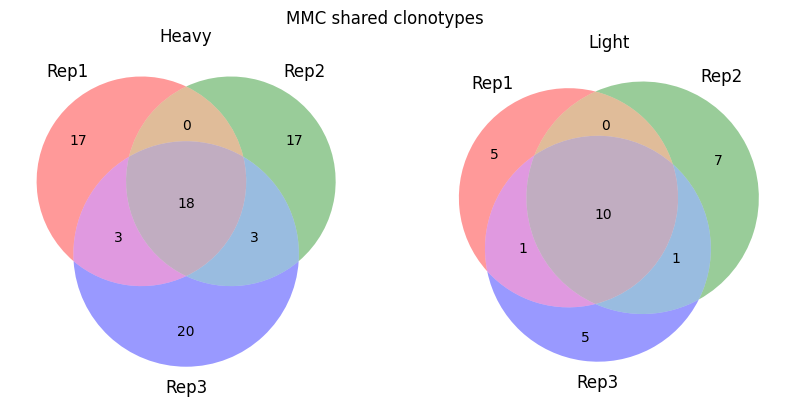

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

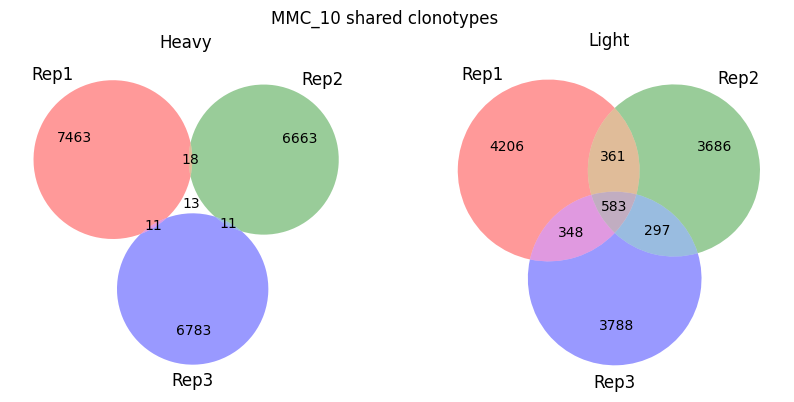

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

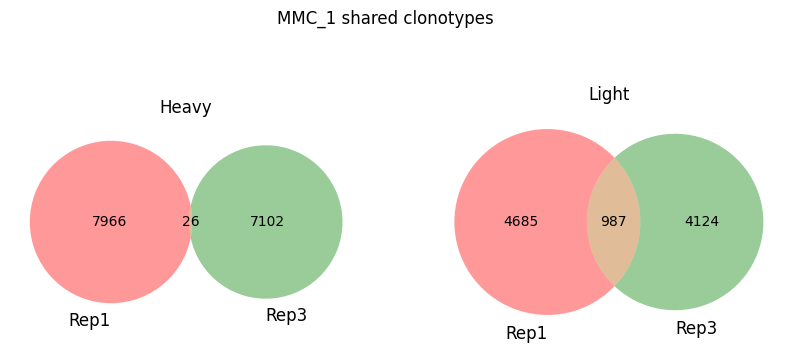

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

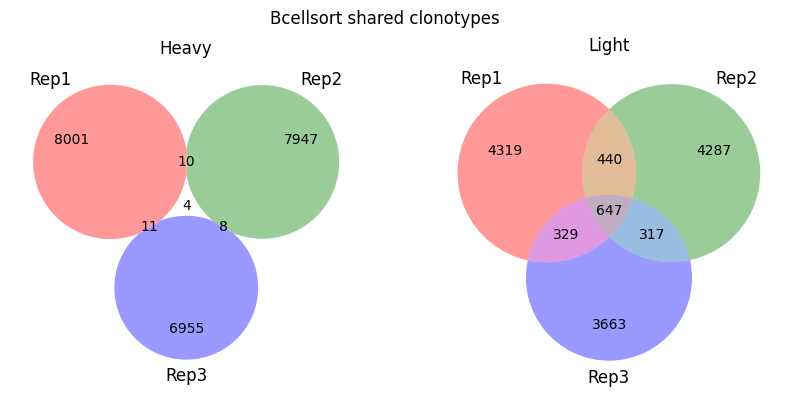

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

In [35]:
# Plot venn diagram of shared clonotypes for all samples
import pandas as pd
from matplotlib_venn import venn3, venn2
import matplotlib.pyplot as plt

samples = ['MMC','MMC_10', 'MMC_1', 'Bcellsort']

for sample in samples:
    df1 = df_dict[f'5_v2_{sample}_Rep1']
    if sample != 'MMC_1':
        df2 = df_dict[f'5_v2_{sample}_Rep2']
    df3 = df_dict[f'5_v2_{sample}_Rep3']

    # Split each library into heavy and light chain dataframes
    df1_heavy = df1[df1['chain']=='IGH']
    df1_light = df1[(df1['chain']=='IGK') | (df1['chain']=='IGL')]

    if sample != 'MMC_1':
        df2_heavy = df2[df2['chain']=='IGH']
        df2_light = df2[(df2['chain']=='IGK') | (df2['chain']=='IGL')]

    df3_heavy = df3[df3['chain']=='IGH']
    df3_light = df3[(df3['chain']=='IGK') | (df3['chain']=='IGL')]
    
    # Prepare the subplots: Two columns, one for 'Heavy' and one for 'Light'
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    subplots = ['Heavy', 'Light']

    if sample != 'MMC_1':
        sets = [
            (set(df1_heavy.cdr3_nt.unique()), set(df2_heavy.cdr3_nt.unique()), set(df3_heavy.cdr3_nt.unique())),
            (set(df1_light.cdr3_nt.unique()), set(df2_light.cdr3_nt.unique()), set(df3_light.cdr3_nt.unique()))
        ]
    else:
        sets = [
            (set(df1_heavy.cdr3_nt.unique()), set(df3_heavy.cdr3_nt.unique())),
            (set(df1_light.cdr3_nt.unique()), set(df3_light.cdr3_nt.unique()))
        ]

    if sample != 'MMC_1':
        for i, (set1, set2, set3) in enumerate(sets):
            # Plotting the Venn diagram
            ax = axes[i]
            plt.figure(figsize=(4, 4))
            venn = venn3(
                subsets=(set1, set2, set3),
                set_labels=('Rep1', 'Rep2', 'Rep3'),
                ax=ax
            )
            ax.set_title(subplots[i])
    else:
        for i, (set1, set3) in enumerate(sets):
            # Plotting the Venn diagram
            ax = axes[i]
            plt.figure(figsize=(4, 4))
            venn = venn2(
                subsets=(set1, set3),
                set_labels=('Rep1', 'Rep3'),
                ax=ax
            )
            ax.set_title(subplots[i])

    # Add titles and labels
    fig.suptitle(f"{sample} shared clonotypes", y=0.92)



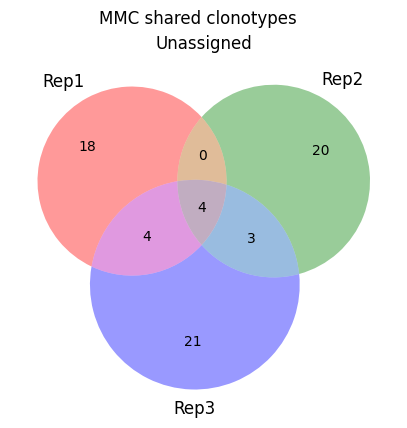

<Figure size 400x400 with 0 Axes>

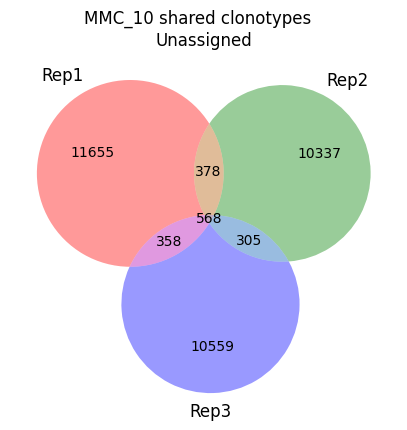

<Figure size 400x400 with 0 Axes>

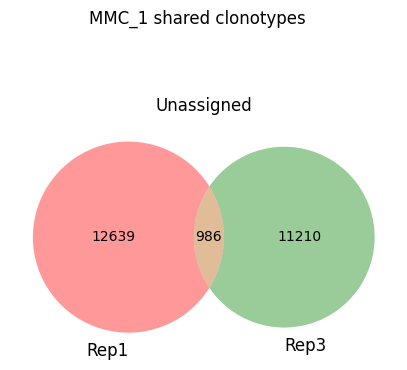

<Figure size 400x400 with 0 Axes>

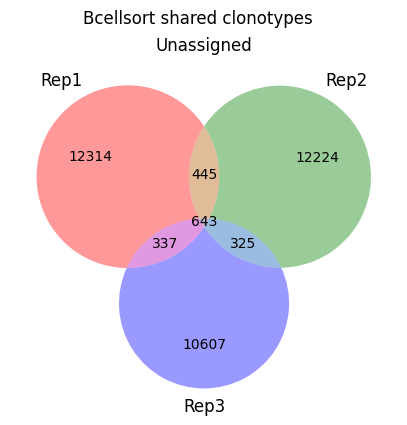

<Figure size 400x400 with 0 Axes>

In [40]:
# Plot venn diagram of shared unassigned clonotypes for all samples
import pandas as pd
from matplotlib_venn import venn3, venn2
import matplotlib.pyplot as plt

samples = ['MMC','MMC_10', 'MMC_1', 'Bcellsort']

for sample in samples:
    df1 = df_dict[f'5_v2_{sample}_Rep1']
    if sample != 'MMC_1':
        df2 = df_dict[f'5_v2_{sample}_Rep2']
    df3 = df_dict[f'5_v2_{sample}_Rep3']

    # Select unassigned clonotypes from each library
    df1_na = df1[df1['cell_line'].isna()]
    if sample != 'MMC_1':
        df2_na = df2[df2['cell_line'].isna()]
    df3_na = df3[df3['cell_line'].isna()]
    
    # Prepare the subplots: Two columns, one for '' and one for 'Unassigned'
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
    axes = [axes]
    subplots = ['Unassigned']

    if sample != 'MMC_1':
        sets = [
            (set(df1_na.cdr3_nt.unique()), set(df2_na.cdr3_nt.unique()), set(df3_na.cdr3_nt.unique())),
        ]
    else:
        sets = [
            (set(df1_na.cdr3_nt.unique()), set(df3_na.cdr3_nt.unique())),
        ]

    if sample != 'MMC_1':
        for i, (set1, set2, set3) in enumerate(sets):
            # Plotting the Venn diagram
            ax = axes[i]
            plt.figure(figsize=(4, 4))
            venn = venn3(
                subsets=(set1, set2, set3),
                set_labels=('Rep1', 'Rep2', 'Rep3'),
                ax=ax
            )
            ax.set_title(subplots[i])
    else:
        for i, (set1, set3) in enumerate(sets):
            # Plotting the Venn diagram
            ax = axes[i]
            plt.figure(figsize=(4, 4))
            venn = venn2(
                subsets=(set1, set3),
                set_labels=('Rep1', 'Rep3'),
                ax=ax
            )
            ax.set_title(subplots[i])

    # Add titles and labels
    fig.suptitle(f"{sample} shared clonotypes", y=0.95)



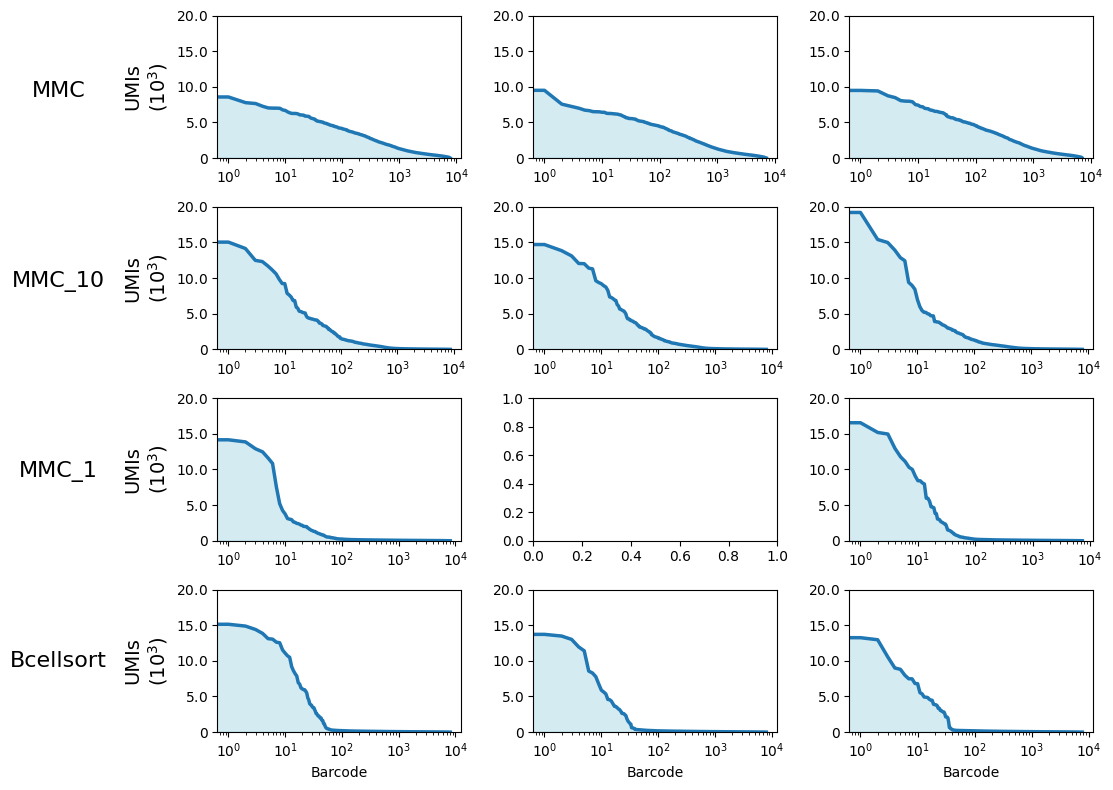

In [135]:
# Plot umis across cell barcodes for all libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# List of patterns for categorizing samples
#patterns = ["MMC_R", "MMC_10_R", "MMC_1_R", "Bcellsort_R"]
patterns = ["MMC", "MMC_10", "MMC_1", "Bcellsort"]

# Prepare the subplots: Two columns, one for 'Heavy' and one for 'Light'
nrows = len(patterns)  # One row per pattern
fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(10, nrows * 2))

# If there's only one row, axes will not be a list, so we make it iterable
if nrows == 1:
    axes = [axes]

# Iterate over patterns to filter and plot the data
for i, pattern in enumerate(patterns):
    # Select keys that match the current pattern
    #matching_keys = [key for key in df_dict.keys() if pattern in key]
    if pattern != 'MMC_1':
        matching_keys = [f'5_v2_{pattern}_Rep1',f'5_v2_{pattern}_Rep2',f'5_v2_{pattern}_Rep3']
    else:
        matching_keys = [f'5_v2_{pattern}_Rep1',f'5_v2_{pattern}_Rep3']

    for j, df_name in enumerate(matching_keys):
        if "Rep1" in df_name:
            df = df_dict[df_name]
            counts = df.groupby('barcode', dropna=False)['umis'].sum()
            counts = counts.sort_values(ascending=False).to_frame().reset_index()
            
            axes[i, 0].plot(counts.index, counts['umis'], marker='', linestyle='-', label=df_name, linewidth=2.5)
            axes[i, 0].fill_between(counts.index, counts['umis'], color='lightblue', alpha=0.5)
            axes[i, 0].set_xscale('log')
            axes[i, 0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"${y/(1e3)}$" if y > 0 else "0"))
            axes[i, 0].set_ylim(0, 20e3)
            axes[i, 0].set_ylabel('UMIs\n' + r'($10^{3}$)',fontsize=14)
            if i == nrows - 1:
                axes[i, 0].set_xlabel('Barcode')

    for j, df_name in enumerate(matching_keys):
        if "Rep2" in df_name:
            df = df_dict[df_name]
            counts = df.groupby('barcode', dropna=False)['umis'].sum()
            counts = counts.sort_values(ascending=False).to_frame().reset_index()
            
            axes[i, 1].plot(counts.index, counts['umis'], marker='', linestyle='-', label=df_name, linewidth=2.5)
            axes[i, 1].fill_between(counts.index, counts['umis'], color='lightblue', alpha=0.5)
            axes[i, 1].set_xscale('log')
            axes[i, 1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"${y/(1e3)}$" if y > 0 else "0"))
            axes[i, 1].set_ylim(0, 20e3)
            if i == nrows - 1:
                axes[i, 1].set_xlabel('Barcode')

    for j, df_name in enumerate(matching_keys):
        if "Rep3" in df_name:
            df = df_dict[df_name]
            counts = df.groupby('barcode', dropna=False)['umis'].sum()
            counts = counts.sort_values(ascending=False).to_frame().reset_index()
            
            axes[i, 2].plot(counts.index, counts['umis'], marker='', linestyle='-', label=df_name, linewidth=2.5)
            axes[i, 2].fill_between(counts.index, counts['umis'], color='lightblue', alpha=0.5)
            axes[i, 2].set_xscale('log')
            axes[i, 2].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"${y/(1e3)}$" if y > 0 else "0"))
            axes[i, 2].set_ylim(0, 20e3)
            if i == nrows - 1:
                axes[i, 2].set_xlabel('Barcode')

    # Add the label to the left of the row (for the current pattern)
    fig.text(-0.05, 0.88 - (0.95*i / nrows), f'{pattern}', ha='center', va='center', fontsize=16, fontweight='regular')

# Adjust layout for better spacing
plt.subplots_adjust(hspace=0.8, wspace=0.25, left=0.22)
plt.tight_layout()
plt.show()


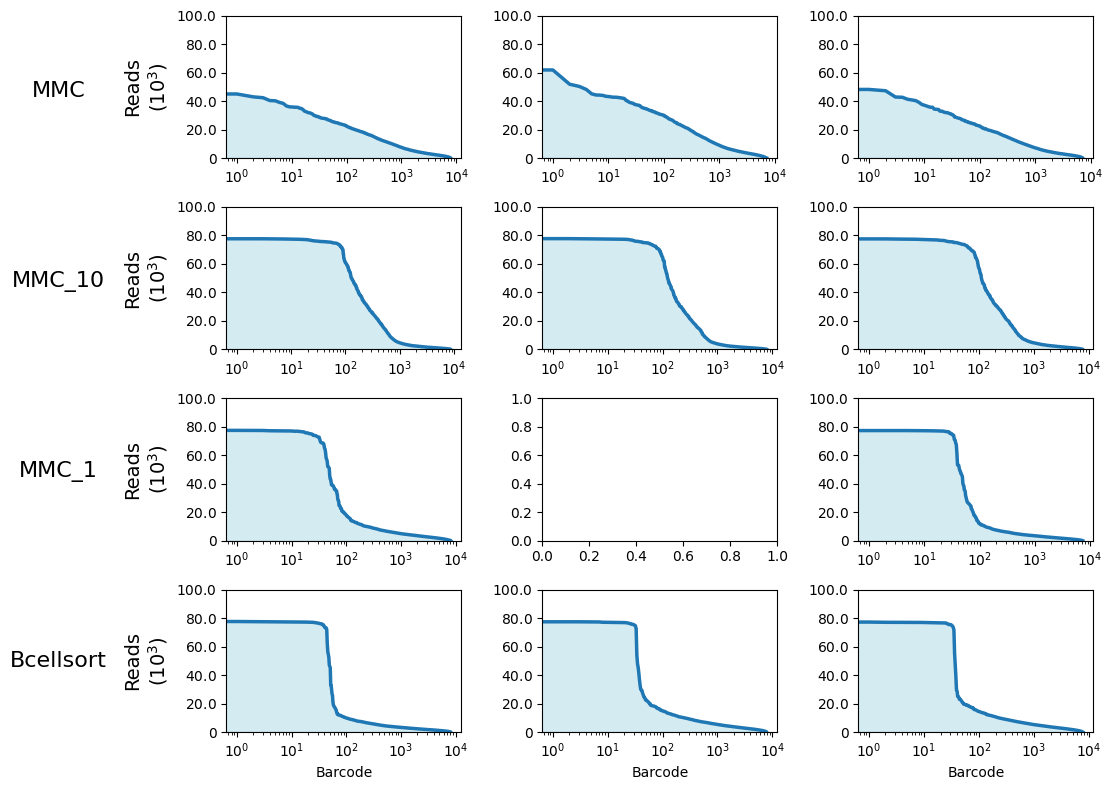

In [138]:
# Plot reads across cell barcodes for all libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# List of patterns for categorizing samples
patterns = ["MMC", "MMC_10", "MMC_1", "Bcellsort"]

# Prepare the subplots: Two columns, one for 'Heavy' and one for 'Light'
nrows = len(patterns)  # One row per pattern
fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(10, nrows * 2))

# If there's only one row, axes will not be a list, so we make it iterable
if nrows == 1:
    axes = [axes]

# Iterate over patterns to filter and plot the data
for i, pattern in enumerate(patterns):
    # Select keys that match the current pattern
    if pattern != 'MMC_1':
        matching_keys = [f'5_v2_{pattern}_Rep1',f'5_v2_{pattern}_Rep2',f'5_v2_{pattern}_Rep3']
    else:
        matching_keys = [f'5_v2_{pattern}_Rep1',f'5_v2_{pattern}_Rep3']
    
    for j, df_name in enumerate(matching_keys):
        if "Rep1" in df_name:
            df = df_dict[df_name]
            counts = df.groupby('barcode', dropna=False)['reads'].sum()
            counts = counts.sort_values(ascending=False).to_frame().reset_index()
            
            axes[i, 0].plot(counts.index, counts['reads'], marker='', linestyle='-', label=df_name, linewidth=2.5)
            axes[i, 0].fill_between(counts.index, counts['reads'], color='lightblue', alpha=0.5)
            axes[i, 0].set_xscale('log')
            axes[i, 0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"${y/(1e3)}$" if y > 0 else "0"))
            axes[i, 0].set_ylim(0, 100e3)
            axes[i, 0].set_ylabel('Reads\n' + r'($10^{3}$)',fontsize=14)
            if i == nrows - 1:
                axes[i, 0].set_xlabel('Barcode')

    for j, df_name in enumerate(matching_keys):
        if "Rep2" in df_name:
            df = df_dict[df_name]
            counts = df.groupby('barcode', dropna=False)['reads'].sum()
            counts = counts.sort_values(ascending=False).to_frame().reset_index()
            
            axes[i, 1].plot(counts.index, counts['reads'], marker='', linestyle='-', label=df_name, linewidth=2.5)
            axes[i, 1].fill_between(counts.index, counts['reads'], color='lightblue', alpha=0.5)
            axes[i, 1].set_xscale('log')
            axes[i, 1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"${y/(1e3)}$" if y > 0 else "0"))
            axes[i, 1].set_ylim(0, 100e3)
            if i == nrows - 1:
                axes[i, 1].set_xlabel('Barcode')

    for j, df_name in enumerate(matching_keys):
        if "Rep3" in df_name:
            df = df_dict[df_name]
            counts = df.groupby('barcode', dropna=False)['reads'].sum()
            counts = counts.sort_values(ascending=False).to_frame().reset_index()
            
            axes[i, 2].plot(counts.index, counts['reads'], marker='', linestyle='-', label=df_name, linewidth=2.5)
            axes[i, 2].fill_between(counts.index, counts['reads'], color='lightblue', alpha=0.5)
            axes[i, 2].set_xscale('log')
            axes[i, 2].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"${y/(1e3)}$" if y > 0 else "0"))
            axes[i, 2].set_ylim(0, 100e3)
            if i == nrows - 1:
                axes[i, 2].set_xlabel('Barcode')

    # Add the label to the left of the row (for the current pattern)
    fig.text(-0.05, 0.88 - (0.95*i / nrows), f'{pattern}', ha='center', va='center', fontsize=16, fontweight='regular')

# Adjust layout for better spacing
plt.subplots_adjust(hspace=0.8, wspace=0.25, left=0.22)
plt.tight_layout()
plt.show()


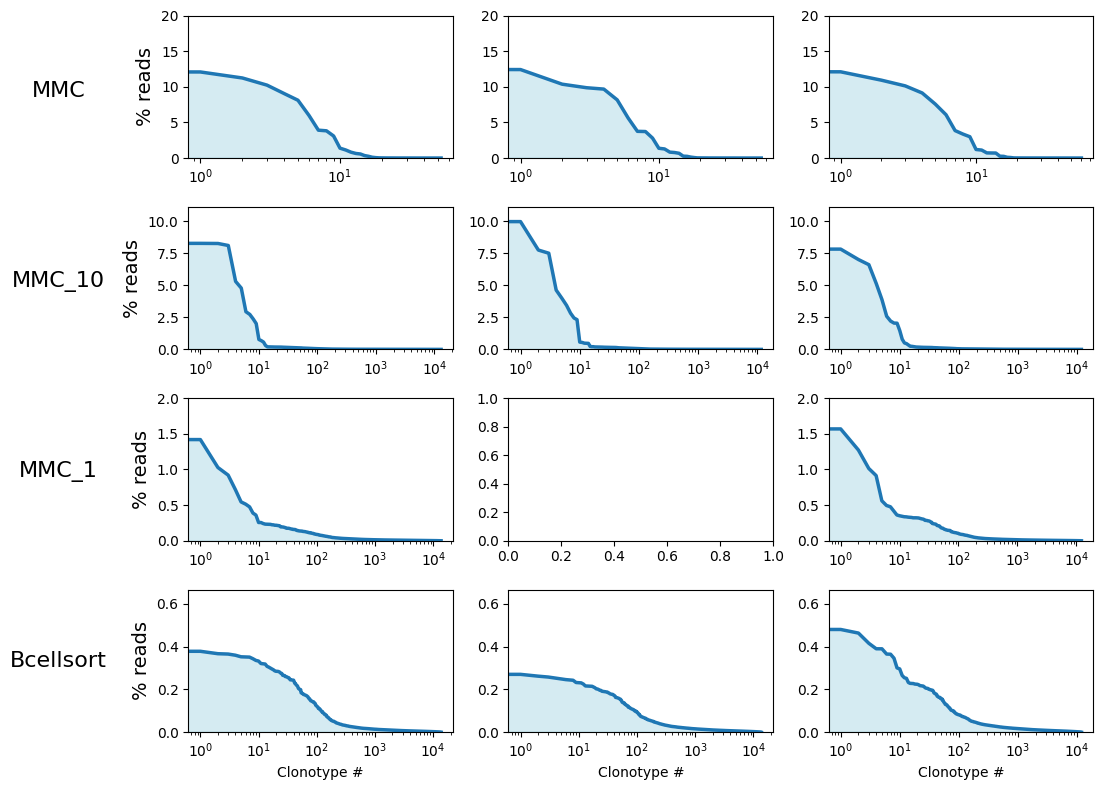

In [154]:
# Plot reads across clonotypes for all libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# List of patterns for categorizing samples
patterns = ["MMC", "MMC_10", "MMC_1", "Bcellsort"]

# Prepare the subplots: Two columns, one for 'Heavy' and one for 'Light'
nrows = len(patterns)  # One row per pattern
fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(10, nrows * 2))

# If there's only one row, axes will not be a list, so we make it iterable
if nrows == 1:
    axes = [axes]

# Iterate over patterns to filter and plot the data
for i, pattern in enumerate(patterns):
    # Select keys that match the current pattern
    if pattern != 'MMC_1':
        matching_keys = [f'5_v2_{pattern}_Rep1',f'5_v2_{pattern}_Rep2',f'5_v2_{pattern}_Rep3']
    else:
        matching_keys = [f'5_v2_{pattern}_Rep1',f'5_v2_{pattern}_Rep3']
    
    yscale = [1,1.8,10,30]

    for j, df_name in enumerate(matching_keys):
        if "Rep1" in df_name:
            df = df_dict[df_name]
            counts = df.groupby('cdr3_nt', dropna=False)['reads'].sum()
            counts = counts.sort_values(ascending=False).to_frame().reset_index()
            
            # Normalize reads to obtain reads_fraction
            total_reads = counts['reads'].sum()
            counts['reads_fraction'] = counts['reads'] * 100 / total_reads

            axes[i, 0].plot(counts.index, counts['reads_fraction'], marker='', linestyle='-', label=df_name, linewidth=2.5)
            axes[i, 0].fill_between(counts.index, counts['reads_fraction'], color='lightblue', alpha=0.5)
            axes[i, 0].set_xscale('log')
            #axes[i, 0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"${y/(1e6)}$" if y > 0 else "0"))

            axes[i, 0].set_ylim(0, 20/yscale[i])
            axes[i, 0].set_ylabel("% reads",fontsize=14)#\n(millions)')
            if i == nrows - 1:
                axes[i, 0].set_xlabel('Clonotype #')

    for j, df_name in enumerate(matching_keys):
        if "Rep2" in df_name:
            df = df_dict[df_name]
            counts = df.groupby('cdr3_nt', dropna=False)['reads'].sum()
            counts = counts.sort_values(ascending=False).to_frame().reset_index()
            
            # Normalize reads to obtain reads_fraction
            total_reads = counts['reads'].sum()
            counts['reads_fraction'] = counts['reads'] * 100 / total_reads

            axes[i, 1].plot(counts.index, counts['reads_fraction'], marker='', linestyle='-', label=df_name, linewidth=2.5)
            axes[i, 1].fill_between(counts.index, counts['reads_fraction'], color='lightblue', alpha=0.5)
            axes[i, 1].set_xscale('log')
            #axes[i, 1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"${y/(1e6)}$" if y > 0 else "0"))
            axes[i, 1].set_ylim(0, 20/yscale[i])
            if i == nrows - 1:
                axes[i, 1].set_xlabel('Clonotype #')

    for j, df_name in enumerate(matching_keys):
        if "Rep3" in df_name:
            df = df_dict[df_name]
            counts = df.groupby('cdr3_nt', dropna=False)['reads'].sum()
            counts = counts.sort_values(ascending=False).to_frame().reset_index()
            
            # Normalize reads to obtain reads_fraction
            total_reads = counts['reads'].sum()
            counts['reads_fraction'] = counts['reads'] * 100 / total_reads

            axes[i, 2].plot(counts.index, counts['reads_fraction'], marker='', linestyle='-', label=df_name, linewidth=2.5)
            axes[i, 2].fill_between(counts.index, counts['reads_fraction'], color='lightblue', alpha=0.5)
            axes[i, 2].set_xscale('log')
            #axes[i, 2].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"${y/(1e6)}$" if y > 0 else "0"))
            axes[i, 2].set_ylim(0, 20/yscale[i])
            if i == nrows - 1:
                axes[i, 2].set_xlabel('Clonotype #')

    # Add the label to the left of the row (for the current pattern)
    fig.text(-0.05, 0.88 - (0.95*i / nrows), f'{pattern}', ha='center', va='center', fontsize=16, fontweight='regular')

# Adjust layout for better spacing
plt.subplots_adjust(hspace=0.8, wspace=0.25, left=0.22)
plt.tight_layout()
plt.show()


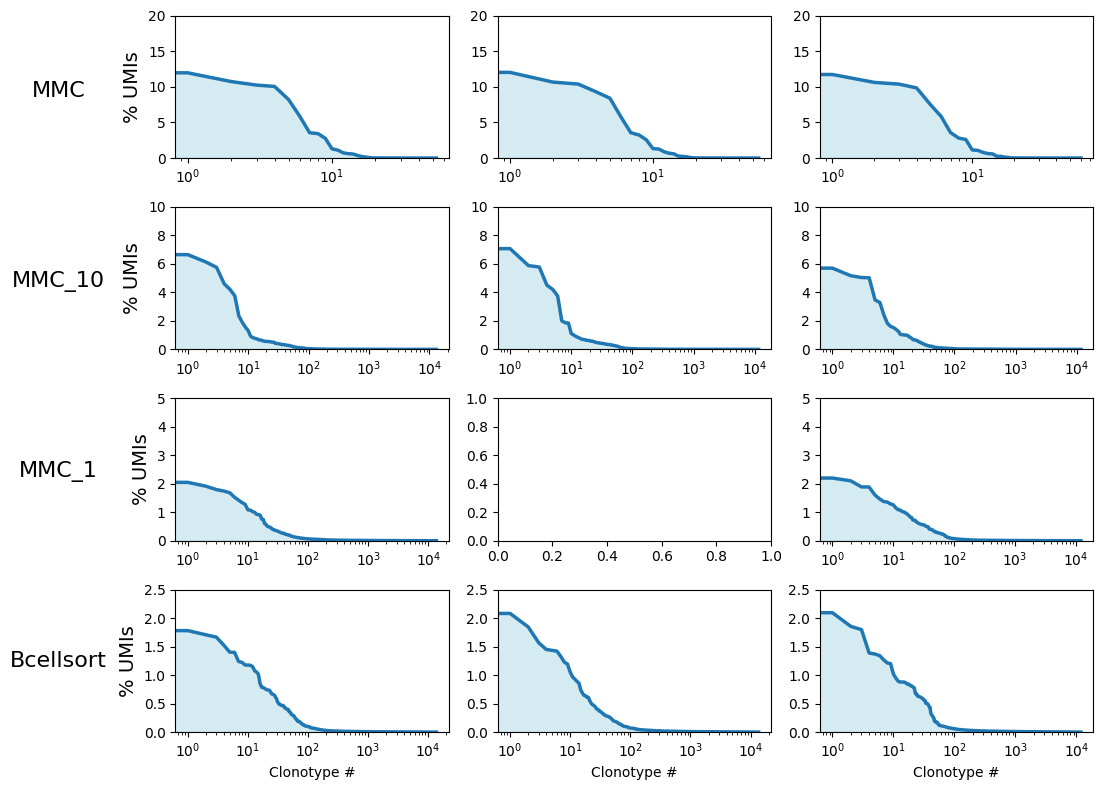

In [150]:
# Plot UMIs across clonotypes for all libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# List of patterns for categorizing samples
patterns = ["MMC", "MMC_10", "MMC_1", "Bcellsort"]

# Prepare the subplots: Two columns, one for 'Heavy' and one for 'Light'
nrows = len(patterns)  # One row per pattern
fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(10, nrows * 2))

# If there's only one row, axes will not be a list, so we make it iterable
if nrows == 1:
    axes = [axes]

# Iterate over patterns to filter and plot the data
for i, pattern in enumerate(patterns):
    # Select keys that match the current pattern
    if pattern != 'MMC_1':
        matching_keys = [f'5_v2_{pattern}_Rep1',f'5_v2_{pattern}_Rep2',f'5_v2_{pattern}_Rep3']
    else:
        matching_keys = [f'5_v2_{pattern}_Rep1',f'5_v2_{pattern}_Rep3']
    
    for j, df_name in enumerate(matching_keys):
        if "Rep1" in df_name:
            df = df_dict[df_name]
            counts = df.groupby('cdr3_nt', dropna=False)['umis'].sum()
            counts = counts.sort_values(ascending=False).to_frame().reset_index()
            
            # Normalize umis to obtain umi_fraction
            total_umis = counts['umis'].sum()
            counts['umi_fraction'] = counts['umis'] * 100 / total_umis
            
            axes[i, 0].plot(counts.index, counts['umi_fraction'], marker='', linestyle='-', label=df_name, linewidth=2.5)
            axes[i, 0].fill_between(counts.index, counts['umi_fraction'], color='lightblue', alpha=0.5)
            axes[i, 0].set_xscale('log')
            #axes[i, 0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"${y/(1e6)}$" if y > 0 else "0"))
            axes[i, 0].set_ylim(0, 20/(2**i))
            axes[i, 0].set_ylabel('% UMIs',fontsize=14)
            if i == nrows - 1:
                axes[i, 0].set_xlabel('Clonotype #')

    for j, df_name in enumerate(matching_keys):
        if "Rep2" in df_name:
            df = df_dict[df_name]
            counts = df.groupby('cdr3_nt', dropna=False)['umis'].sum()
            counts = counts.sort_values(ascending=False).to_frame().reset_index()
            
            # Normalize umis to obtain umi_fraction
            total_umis = counts['umis'].sum()
            counts['umi_fraction'] = counts['umis'] * 100 / total_umis

            axes[i, 1].plot(counts.index, counts['umi_fraction'], marker='', linestyle='-', label=df_name, linewidth=2.5)
            axes[i, 1].fill_between(counts.index, counts['umi_fraction'], color='lightblue', alpha=0.5)
            axes[i, 1].set_xscale('log')
            #axes[i, 1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"${y/(1e6)}$" if y > 0 else "0"))
            axes[i, 1].set_ylim(0, 20/(2**i))
            if i == nrows - 1:
                axes[i, 1].set_xlabel('Clonotype #')

    for j, df_name in enumerate(matching_keys):
        if "Rep3" in df_name:
            df = df_dict[df_name]
            counts = df.groupby('cdr3_nt', dropna=False)['umis'].sum()
            counts = counts.sort_values(ascending=False).to_frame().reset_index()
            
            # Normalize umis to obtain umi_fraction
            total_umis = counts['umis'].sum()
            counts['umi_fraction'] = counts['umis'] * 100 / total_umis

            axes[i, 2].plot(counts.index, counts['umi_fraction'], marker='', linestyle='-', label=df_name, linewidth=2.5)
            axes[i, 2].fill_between(counts.index, counts['umi_fraction'], color='lightblue', alpha=0.5)
            axes[i, 2].set_xscale('log')
            #axes[i, 2].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"${y/(1e6)}$" if y > 0 else "0"))
            axes[i, 2].set_ylim(0, 20/(2**i))
            if i == nrows - 1:
                axes[i, 2].set_xlabel('Clonotype #')

    # Add the label to the left of the row (for the current pattern)
    fig.text(-0.05, 0.88 - (0.95*i / nrows), f'{pattern}', ha='center', va='center', fontsize=16, fontweight='regular')

# Adjust layout for better spacing
plt.subplots_adjust(hspace=0.8, wspace=0.25, left=0.22)
plt.tight_layout()
plt.show()


In [3]:
## 10X Genomics ONLY - Summarize umi counts and cell line assignments for all of the samples in df_dict
# Create an empty dataframe for the summary
summary_df = pd.DataFrame()

# Iterate over the dictionary and build the initial summary
for sample_name, df in df_dict.items():
    # Split df into df_IGH and df_IGKL
    df_IGH = df[df['chain']=='IGH']
    df_IGKL = df[(df['chain']=='IGK') | (df['chain']=='IGL')]

    igh_cell_line_counts = df_IGH.groupby('cell_line',dropna=False)['umis'].sum()
    new_row = igh_cell_line_counts.to_frame().T
    new_row["totalCellCount"] = df_IGH.barcode.unique().shape[0]
    new_row["totalUMICounts"] = df_IGH.umis.sum() # UMIs: .umis.sum(); clonotypes: .cdr3.unique().shape[0]
    new_row["totalClonotypeCount"] = df_IGH.cdr3.unique().shape[0] # UMIs: .umis.sum(); clonotypes: .cdr3.unique().shape[0]
    new_row.index = [sample_name+"__Heavy."]
    summary_df = pd.concat([summary_df, new_row], axis=0)

    igkl_cell_line_counts = df_IGKL.groupby('cell_line',dropna=False)['umis'].sum()
    new_row = igkl_cell_line_counts.to_frame().T
    new_row["totalCellCount"] = df_IGKL.barcode.unique().shape[0]
    new_row["totalUMICounts"] = df_IGKL.umis.sum() # UMIs: .umis.sum(); clonotypes: .cdr3.unique().shape[0]
    new_row["totalClonotypeCount"] = df_IGKL.cdr3.unique().shape[0] # UMIs: .umis.sum(); clonotypes: .cdr3.unique().shape[0]
    new_row.index = [sample_name+"__Light."]
    summary_df = pd.concat([summary_df, new_row], axis=0)

# Fill missing values with 0
summary_df.fillna(0, inplace=True)

# DEBUG: Check the initial summary dataframe
print("Initial Summary DataFrame:")
print(summary_df)

# Adjusted regex to capture base sample name and type (IGH, IGL, IGK)
for index,row in summary_df.iterrows():    
    summary_df.at[index, "base_sample"] = find_substring_between_patterns(index,'5_v2_','__')  # Capturing everything before _IG[H/K/L]
    summary_df.at[index, "type"] = find_substring_between_patterns(index,'__','.')  # Capturing IGH, IGK, IGL

# DEBUG: Check extracted base_sample and type columns
#print("\nSummary DataFrame with Extracted Columns:")
#print(summary_df)

# Separate Heavy (IGH) samples
summary_igh = summary_df[summary_df["type"] == "Heavy"].drop(columns=["base_sample", "type"], errors="ignore")

# Separate Light (IGK/L) samples
summary_igkl = summary_df[(summary_df["type"] == "Light")].drop(columns=["base_sample", "type"], errors="ignore")


# DEBUG: Check IGH summary
print("\nSummary for IGH Samples: /home/miguelp95/projects/BCR-SEQC/data/10x/pfda_rerun/v2_summary_IGH.csv")
summary_igh.T.to_csv('/home/miguelp95/projects/BCR-SEQC/data/10x/pfda_rerun/v2_summary_IGH.csv')

# DEBUG: Check IGK/L summary
print("\nCombined Summary for IGL and IGK Samples: /home/miguelp95/projects/BCR-SEQC/data/10x/pfda_rerun/v2_summary_IGKL.csv")
summary_igkl.T.to_csv('/home/miguelp95/projects/BCR-SEQC/data/10x/pfda_rerun/v2_summary_IGKL.csv')

Initial Summary DataFrame:
cell_line                       NaN  totalCellCount  totalUMICounts  \
5pv2_Bcellsort_Rep1__Heavy.  237199            7588          237199   
5pv2_Bcellsort_Rep1__Light.  395884            8015          399948   
5pv2_Bcellsort_Rep2__Heavy.  187151            7503          187151   
5pv2_Bcellsort_Rep2__Light.  307225            7827          308446   
5pv2_Bcellsort_Rep3__Heavy.  193594            7257          193594   
5pv2_Bcellsort_Rep3__Light.  297284            7559          298572   
5pv2_MMC_10_Rep1__Heavy.     206761            7910          348723   
5pv2_MMC_10_Rep1__Light.     339879            8516          758102   
5pv2_MMC_10_Rep2__Heavy.     193970            7188          329469   
5pv2_MMC_10_Rep2__Light.     301998            7802          693952   
5pv2_MMC_10_Rep3__Heavy.     191270            7183          299404   
5pv2_MMC_10_Rep3__Light.     291329            7700          605550   
5pv2_MMC_1_Rep1__Heavy.      179306            767

In [4]:
## 10X Genomics ONLY - Summarize clonotype counts and cell line assignments for all of the samples in df_dict
# Create an empty dataframe for the summary
summary_df = pd.DataFrame()

# Iterate over the dictionary and build the initial summary
for sample_name, df in df_dict.items():
    # Split df into df_IGH and df_IGKL
    df_IGH = df[df['chain']=='IGH']
    df_IGKL = df[(df['chain']=='IGK') | (df['chain']=='IGL')]

    igh_cell_line_counts = df_IGH.groupby('cell_line',dropna=False)['cdr3_nt'].apply(lambda x: x.nunique())
    new_row = igh_cell_line_counts.to_frame().T
    new_row["totalCellCount"] = df_IGH.barcode.unique().shape[0]
    new_row["totalUMICounts"] = df_IGH.umis.sum() # UMIs: .umis.sum(); clonotypes: .cdr3.unique().shape[0]
    new_row["totalClonotypeCount"] = df_IGH.cdr3_nt.unique().shape[0] # UMIs: .umis.sum(); clonotypes: .cdr3.unique().shape[0]
    new_row.index = [sample_name+"__Heavy."]
    summary_df = pd.concat([summary_df, new_row], axis=0)

    igkl_cell_line_counts = df_IGKL.groupby('cell_line',dropna=False)['cdr3_nt'].apply(lambda x: x.nunique())
    new_row = igkl_cell_line_counts.to_frame().T
    new_row["totalCellCount"] = df_IGKL.barcode.unique().shape[0]
    new_row["totalUMICounts"] = df_IGKL.umis.sum() # UMIs: .umis.sum(); clonotypes: .cdr3.unique().shape[0]
    new_row["totalClonotypeCount"] = df_IGKL.cdr3_nt.unique().shape[0] # UMIs: .umis.sum(); clonotypes: .cdr3.unique().shape[0]
    new_row.index = [sample_name+"__Light."]
    summary_df = pd.concat([summary_df, new_row], axis=0)

# Fill missing values with 0
summary_df.fillna(0, inplace=True)

# DEBUG: Check the initial summary dataframe
print("Initial Summary DataFrame:")
print(summary_df)

# Adjusted regex to capture base sample name and type (IGH, IGL, IGK)
for index,row in summary_df.iterrows():    
    summary_df.at[index, "base_sample"] = find_substring_between_patterns(index,'5_v2_','__')  # Capturing everything before _IG[H/K/L]
    summary_df.at[index, "type"] = find_substring_between_patterns(index,'__','.')  # Capturing IGH, IGK, IGL

# DEBUG: Check extracted base_sample and type columns
#print("\nSummary DataFrame with Extracted Columns:")
#print(summary_df)

# Separate Heavy (IGH) samples
summary_igh = summary_df[summary_df["type"] == "Heavy"].drop(columns=["base_sample", "type"], errors="ignore")

# Separate Light (IGK/L) samples
summary_igkl = summary_df[(summary_df["type"] == "Light")].drop(columns=["base_sample", "type"], errors="ignore")


# DEBUG: Check IGH summary
print("\nSummary for IGH Samples: /home/miguelp95/projects/BCR-SEQC/data/10x/pfda_rerun/v2_summary_IGH_clonotypes.csv")
summary_igh.T.to_csv('/home/miguelp95/projects/BCR-SEQC/data/10x/pfda_rerun/v2_summary_IGH_clonotypes.csv')

# DEBUG: Check IGK/L summary
print("\nCombined Summary for IGL and IGK Samples: /home/miguelp95/projects/BCR-SEQC/data/10x/pfda_rerun/v2_summary_IGKL_clonotypes.csv")
summary_igkl.T.to_csv('/home/miguelp95/projects/BCR-SEQC/data/10x/pfda_rerun/v2_summary_IGKL_clonotypes.csv')

Initial Summary DataFrame:
cell_line                     NaN  totalCellCount  totalUMICounts  \
5pv2_Bcellsort_Rep1__Heavy.  8037            7588          237199   
5pv2_Bcellsort_Rep1__Light.  5716            8015          399948   
5pv2_Bcellsort_Rep2__Heavy.  7980            7503          187151   
5pv2_Bcellsort_Rep2__Light.  5671            7827          308446   
5pv2_Bcellsort_Rep3__Heavy.  6979            7257          193594   
5pv2_Bcellsort_Rep3__Light.  4939            7559          298572   
5pv2_MMC_10_Rep1__Heavy.     7509            7910          348723   
5pv2_MMC_10_Rep1__Light.     5470            8516          758102   
5pv2_MMC_10_Rep2__Heavy.     6696            7188          329469   
5pv2_MMC_10_Rep2__Light.     4892            7802          693952   
5pv2_MMC_10_Rep3__Heavy.     6810            7183          299404   
5pv2_MMC_10_Rep3__Light.     4982            7700          605550   
5pv2_MMC_1_Rep1__Heavy.      7988            7671          190789   
5pv2_MM

In [5]:
## 10X Genomics ONLY - Summarize cell counts and cell line assignments for all of the samples in df_dict
# Create an empty dataframe for the summary
summary_df = pd.DataFrame()

# Iterate over the dictionary and build the initial summary
for sample_name, df in df_dict.items():
    # Split df into df_IGH and df_IGKL
    df_IGH = df[df['chain']=='IGH']
    df_IGKL = df[(df['chain']=='IGK') | (df['chain']=='IGL')]

    igh_cell_line_counts = df_IGH.groupby('cell_line',dropna=False)['barcode'].apply(lambda x: x.nunique())
    new_row = igh_cell_line_counts.to_frame().T
    new_row["totalCellCount"] = df_IGH.barcode.unique().shape[0]
    new_row["totalUMICounts"] = df_IGH.umis.sum() # UMIs: .umis.sum(); clonotypes: .cdr3.unique().shape[0]
    new_row["totalClonotypeCount"] = df_IGH.cdr3_nt.unique().shape[0] # UMIs: .umis.sum(); clonotypes: .cdr3.unique().shape[0]
    new_row.index = [sample_name+"__Heavy."]
    summary_df = pd.concat([summary_df, new_row], axis=0)

    igkl_cell_line_counts = df_IGKL.groupby('cell_line',dropna=False)['barcode'].apply(lambda x: x.nunique())
    new_row = igkl_cell_line_counts.to_frame().T
    new_row["totalCellCount"] = df_IGKL.barcode.unique().shape[0]
    new_row["totalUMICounts"] = df_IGKL.umis.sum() # UMIs: .umis.sum(); clonotypes: .cdr3.unique().shape[0]
    new_row["totalClonotypeCount"] = df_IGKL.cdr3_nt.unique().shape[0] # UMIs: .umis.sum(); clonotypes: .cdr3.unique().shape[0]
    new_row.index = [sample_name+"__Light."]
    summary_df = pd.concat([summary_df, new_row], axis=0)

# Fill missing values with 0
summary_df.fillna(0, inplace=True)

# DEBUG: Check the initial summary dataframe
print("Initial Summary DataFrame:")
print(summary_df)

# Adjusted regex to capture base sample name and type (IGH, IGL, IGK)
for index,row in summary_df.iterrows():    
    summary_df.at[index, "base_sample"] = find_substring_between_patterns(index,'5_v2_','__')  # Capturing everything before _IG[H/K/L]
    summary_df.at[index, "type"] = find_substring_between_patterns(index,'__','.')  # Capturing IGH, IGK, IGL

# DEBUG: Check extracted base_sample and type columns
#print("\nSummary DataFrame with Extracted Columns:")
#print(summary_df)

# Separate Heavy (IGH) samples
summary_igh = summary_df[summary_df["type"] == "Heavy"].drop(columns=["base_sample", "type"], errors="ignore")

# Separate Light (IGK/L) samples
summary_igkl = summary_df[(summary_df["type"] == "Light")].drop(columns=["base_sample", "type"], errors="ignore")


# DEBUG: Check IGH summary
print("\nSummary for IGH Samples: /home/miguelp95/projects/BCR-SEQC/data/10x/pfda_rerun/v2_summary_IGH_cells.csv")
summary_igh.T.to_csv('/home/miguelp95/projects/BCR-SEQC/data/10x/pfda_rerun/v2_summary_IGH_cells.csv')

# DEBUG: Check IGK/L summary
print("\nCombined Summary for IGL and IGK Samples: /home/miguelp95/projects/BCR-SEQC/data/10x/pfda_rerun/v2_summary_IGKL_cells.csv")
summary_igkl.T.to_csv('/home/miguelp95/projects/BCR-SEQC/data/10x/pfda_rerun/v2_summary_IGKL_cells.csv')

Initial Summary DataFrame:
cell_line                     NaN  totalCellCount  totalUMICounts  \
5pv2_Bcellsort_Rep1__Heavy.  7588            7588          237199   
5pv2_Bcellsort_Rep1__Light.  7943            8015          399948   
5pv2_Bcellsort_Rep2__Heavy.  7503            7503          187151   
5pv2_Bcellsort_Rep2__Light.  7779            7827          308446   
5pv2_Bcellsort_Rep3__Heavy.  7257            7257          193594   
5pv2_Bcellsort_Rep3__Light.  7494            7559          298572   
5pv2_MMC_10_Rep1__Heavy.     7083            7910          348723   
5pv2_MMC_10_Rep1__Light.     7505            8516          758102   
5pv2_MMC_10_Rep2__Heavy.     6434            7188          329469   
5pv2_MMC_10_Rep2__Light.     6828            7802          693952   
5pv2_MMC_10_Rep3__Heavy.     6499            7183          299404   
5pv2_MMC_10_Rep3__Light.     6801            7700          605550   
5pv2_MMC_1_Rep1__Heavy.      7585            7671          190789   
5pv2_MM

In [6]:
## 10X Genomics ONLY - New logic for filtering "doublets" when reporting cell counts and cataloguing doublet count per library
import pandas as pd

# Create an empty dataframe for the main summary and the duplicates summary
summary_df = pd.DataFrame()
multiplet_df = pd.DataFrame()
dups_summary = pd.DataFrame(columns=["sample_name", "IGH_dups", "IGKL_dups"])

# Iterate over the dictionary and build the summaries
for sample_name, df in df_dict.items():
    # Initialize duplicate counts
    IGH_dups = 0
    IGKL_dups = 0

    # Initialize df copy and drop undefined cell_line entries
    df_filtered = df.copy().dropna(subset=['cell_line'])

    # Identify potential duplicate entries
    df_duplicates = df_filtered[df_filtered.duplicated(subset=["barcode", "chain"], keep=False)]

    # Filter out duplicates by retaining the entry that matches the corresponding opposite chain's cell_line
    for barcode in df_duplicates["barcode"].unique():
        sub_df = df_filtered[df_filtered["barcode"] == barcode]
        # Separate IGH and IGK/IGL entries
        igh_entries = sub_df[sub_df["chain"] == "IGH"]
        igkl_entries = sub_df[(sub_df["chain"] == "IGK") | (sub_df["chain"] == "IGL")]
        
        # Check for IGH duplicates
        if len(igh_entries) > 1:
            # Identify rows to drop
            for _, row in igh_entries.iterrows():
                # If no matching cell_line in IGK/IGL, drop the row
                if not igkl_entries["cell_line"].eq(row["cell_line"]).any():
                    df_filtered.drop(index=row.name, inplace=True)
                    IGH_dups += 1
        
        # Check for IGK/IGL duplicates
        if len(igkl_entries) > 1:
            # Identify rows to drop
            for _, row in igkl_entries.iterrows():
                # If no matching cell_line in IGH, drop the row
                if not igh_entries["cell_line"].eq(row["cell_line"]).any():
                    df_filtered.drop(index=row.name, inplace=True)
                    IGKL_dups += 1

    # Add a row to the duplicates summary
    dups_summary = pd.concat([dups_summary, pd.DataFrame({
        "sample_name": [sample_name],
        "IGH_dups": [IGH_dups],
        "IGKL_dups": [IGKL_dups]
    })], ignore_index=True)

    # Calculate combined summary
    cell_line_counts = df_filtered.drop_duplicates(subset='barcode').groupby("cell_line")["barcode"].nunique()
    new_row = cell_line_counts.to_frame().T
    new_row["totalCellCount"] = df["barcode"].nunique()
    #new_row["totalUMICounts"] = df_filtered["umis"].sum()
    #new_row["totalClonotypeCount"] = df_filtered["cdr3_nt"].nunique()
    new_row.index = [sample_name + "."]
    summary_df = pd.concat([summary_df, new_row], axis=0)

    # Generate multiplet summary
    clonotypes_per_barcode = df['barcode'].value_counts().value_counts().to_frame().T
    print(f"[{sample_name}]: multiplets...\n {clonotypes_per_barcode}")
    clonotypes_per_barcode.index = [sample_name]
    multiplet_df = pd.concat([multiplet_df,clonotypes_per_barcode],axis=0)

    # Check residual duplicates
    # Find values in column 'barcode' that appear more than n times
    frequent_values = df_filtered['barcode'].value_counts()[df_filtered['barcode'].value_counts() > 2].index
    print(f"[{sample_name}]: {len(frequent_values)} residual duplicates")

    # Find barcodes with duplicate heavy OR light chain entries
    df_filtered_igh = df_filtered[df_filtered['chain']=='IGH']
    frequent_values_igh = df_filtered_igh['barcode'].value_counts()[df_filtered_igh['barcode'].value_counts() > 1].index
    df_filtered_igkl = df_filtered[(df_filtered['chain']=='IGK') | (df_filtered['chain']=='IGL')]
    frequent_values_igkl = df_filtered_igkl['barcode'].value_counts()[df_filtered_igkl['barcode'].value_counts() > 1].index
    print(f"[{sample_name}]: {len(frequent_values_igh)} residual duplicate IGH")
    print(f"[{sample_name}]: {len(frequent_values_igkl)} residual duplicate IGKL")

# Fill missing values in the summary DataFrame with 0
summary_df.fillna(0, inplace=True)
multiplet_df.fillna(0, inplace=True)

# Save or display the summaries
print("\nMain Summary DataFrame: /home/miguelp95/projects/BCR-SEQC/data/10x/pfda_rerun/v2_summary_combined_cells.csv")
summary_df.T.to_csv('/home/miguelp95/projects/BCR-SEQC/data/10x/pfda_rerun/v2_summary_combined_cells.csv')

print("\nDuplicates Summary DataFrame: /home/miguelp95/projects/BCR-SEQC/data/10x/pfda_rerun/v2_dups_summary.csv")
dups_summary.T.to_csv('/home/miguelp95/projects/BCR-SEQC/data/10x/pfda_rerun/v2_dups_summary.csv')

print("\nMultiplets Summary DataFrame: /home/miguelp95/projects/BCR-SEQC/data/10x/pfda_rerun/v2_multiplet_summary.csv")
multiplet_df.T.to_csv('/home/miguelp95/projects/BCR-SEQC/data/10x/pfda_rerun/v2_multiplet_summary.csv')

[5pv2_Bcellsort_Rep1]: multiplets...
 count     2    3    1    4
count  6292  741  631  453
[5pv2_Bcellsort_Rep1]: 0 residual duplicates
[5pv2_Bcellsort_Rep1]: 0 residual duplicate IGH
[5pv2_Bcellsort_Rep1]: 0 residual duplicate IGKL
[5pv2_Bcellsort_Rep2]: multiplets...
 count     2    3    1    4
count  6336  576  562  472
[5pv2_Bcellsort_Rep2]: 0 residual duplicates
[5pv2_Bcellsort_Rep2]: 0 residual duplicate IGH
[5pv2_Bcellsort_Rep2]: 0 residual duplicate IGKL
[5pv2_Bcellsort_Rep3]: multiplets...
 count     2    3    1    4
count  6027  648  524  471
[5pv2_Bcellsort_Rep3]: 0 residual duplicates
[5pv2_Bcellsort_Rep3]: 0 residual duplicate IGH
[5pv2_Bcellsort_Rep3]: 0 residual duplicate IGKL
[5pv2_MMC_10_Rep1]: multiplets...
 count     2    1    3    4
count  6717  896  670  378
[5pv2_MMC_10_Rep1]: 0 residual duplicates
[5pv2_MMC_10_Rep1]: 0 residual duplicate IGH
[5pv2_MMC_10_Rep1]: 0 residual duplicate IGKL
[5pv2_MMC_10_Rep2]: multiplets...
 count     2    1    3    4
count  6099  8

In [4]:
## 10X Genomics ONLY - New logic for filtering "doublets" when reporting cell counts and cataloguing doublet count per library
import pandas as pd

# Create an empty dataframe for the main summary and the duplicates summary
summary_df = pd.DataFrame()
multiplet_df = pd.DataFrame()
dups_summary = pd.DataFrame(columns=["sample_name", "IGH_dups", "IGKL_dups"])

# Iterate over the dictionary and build the summaries
for sample_name, df in df_dict.items():
    # Initialize duplicate counts
    IGH_dups = 0
    IGKL_dups = 0

    # Initialize df copy and drop undefined cell_line entries
    df_filtered = df.copy().dropna(subset=['cell_line'])

    # Identify potential duplicate entries
    df_duplicates = df_filtered[df_filtered.duplicated(subset=["barcode", "chain"], keep=False)]

    # Filter out duplicates by retaining the entry that matches the corresponding opposite chain's cell_line
    for barcode in df_duplicates["barcode"].unique():
        sub_df = df_filtered[df_filtered["barcode"] == barcode]
        # Separate IGH and IGK/IGL entries
        igh_entries = sub_df[sub_df["chain"] == "IGH"]
        igkl_entries = sub_df[(sub_df["chain"] == "IGK") | (sub_df["chain"] == "IGL")]
        
        # Check for IGH duplicates
        if len(igh_entries) > 1:
            # Identify rows to drop
            for _, row in igh_entries.iterrows():
                # If no matching cell_line in IGK/IGL, drop the row
                if not igkl_entries["cell_line"].eq(row["cell_line"]).any():
                    df_filtered.drop(index=row.name, inplace=True)
                    IGH_dups += 1
        
        # Check for IGK/IGL duplicates
        if len(igkl_entries) > 1:
            # Identify rows to drop
            for _, row in igkl_entries.iterrows():
                # If no matching cell_line in IGH, drop the row
                if not igh_entries["cell_line"].eq(row["cell_line"]).any():
                    df_filtered.drop(index=row.name, inplace=True)
                    IGKL_dups += 1

    # Add a row to the duplicates summary
    dups_summary = pd.concat([dups_summary, pd.DataFrame({
        "sample_name": [sample_name],
        "IGH_dups": [IGH_dups],
        "IGKL_dups": [IGKL_dups]
    })], ignore_index=True)

    # Calculate combined summary
    cell_line_counts = df_filtered.drop_duplicates(subset='barcode').groupby("cell_line")["barcode"].nunique()
    new_row = cell_line_counts.to_frame().T
    new_row["totalCellCount"] = df["barcode"].nunique()
    #new_row["totalUMICounts"] = df_filtered["umis"].sum()
    #new_row["totalClonotypeCount"] = df_filtered["cdr3_nt"].nunique()
    new_row.index = [sample_name + "."]
    summary_df = pd.concat([summary_df, new_row], axis=0)

    # Generate multiplet summary

    df['barcode_chain'] = df['barcode'] + '_' + df['chain']
    counts = df[['barcode']].value_counts().to_frame() #.value_counts().to_frame().T
    barcodes_2_list = counts[counts['count']==2].reset_index().barcode.to_list()
    barcodes_2 = df[df['barcode'].isin(barcodes_2_list)]
    barcodes_2_by_chain = barcodes_2['chain'].value_counts().to_frame()
    barcodes_2_by_chain['sample_chain'] = sample_name + '_' + barcodes_2_by_chain.index
    barcodes_2_by_chain.set_index('sample_chain')

    clonotypes_per_barcode = df[['barcode']].value_counts().value_counts().to_frame().T
    print(f"[{sample_name}]: multiplets...\n {clonotypes_per_barcode}")
    clonotypes_per_barcode.index = [sample_name]
    multiplet_df = pd.concat([multiplet_df,clonotypes_per_barcode],axis=0)

    

    # Check residual duplicates
    # Find values in column 'barcode' that appear more than n times
    frequent_values = df_filtered['barcode'].value_counts()[df_filtered['barcode'].value_counts() > 2].index
    print(f"[{sample_name}]: {len(frequent_values)} residual duplicates")

    # Find barcodes with duplicate heavy OR light chain entries
    df_filtered_igh = df_filtered[df_filtered['chain']=='IGH']
    frequent_values_igh = df_filtered_igh['barcode'].value_counts()[df_filtered_igh['barcode'].value_counts() > 1].index
    df_filtered_igkl = df_filtered[(df_filtered['chain']=='IGK') | (df_filtered['chain']=='IGL')]
    frequent_values_igkl = df_filtered_igkl['barcode'].value_counts()[df_filtered_igkl['barcode'].value_counts() > 1].index
    print(f"[{sample_name}]: {len(frequent_values_igh)} residual duplicate IGH")
    print(f"[{sample_name}]: {len(frequent_values_igkl)} residual duplicate IGKL")

# Fill missing values in the summary DataFrame with 0
summary_df.fillna(0, inplace=True)
multiplet_df.fillna(0, inplace=True)

# Save or display the summaries
print("\nMain Summary DataFrame: /home/miguelp95/projects/BCR-SEQC/data/10x/v2_results/v2_summary_combined_cells.csv")
#summary_df.T.to_csv('/home/miguelp95/projects/BCR-SEQC/data/10x/v2_results/v2_summary_combined_cells.csv')

print("\nDuplicates Summary DataFrame: /home/miguelp95/projects/BCR-SEQC/data/10x/v2_results/v2_dups_summary.csv")
#dups_summary.T.to_csv('/home/miguelp95/projects/BCR-SEQC/data/10x/v2_results/v2_dups_summary.csv')

print("\nMultiplets Summary DataFrame: /home/miguelp95/projects/BCR-SEQC/data/10x/v2_results/v2_multiplet_summary.csv")
#multiplet_df.T.to_csv('/home/miguelp95/projects/BCR-SEQC/data/10x/v2_results/v2_multiplet_summary.csv')

[5_v2_Bcellsort_Rep1]: multiplets...
 count      1     2
count  14805  1212
[5_v2_Bcellsort_Rep1]: 0 residual duplicates
[5_v2_Bcellsort_Rep1]: 0 residual duplicate IGH
[5_v2_Bcellsort_Rep1]: 0 residual duplicate IGKL
[5_v2_Bcellsort_Rep2]: multiplets...
 count      1     2
count  14663  1083
[5_v2_Bcellsort_Rep2]: 0 residual duplicates
[5_v2_Bcellsort_Rep2]: 0 residual duplicate IGH
[5_v2_Bcellsort_Rep2]: 0 residual duplicate IGKL
[5_v2_Bcellsort_Rep3]: multiplets...
 count      1     2
count  13987  1198
[5_v2_Bcellsort_Rep3]: 0 residual duplicates
[5_v2_Bcellsort_Rep3]: 0 residual duplicate IGH
[5_v2_Bcellsort_Rep3]: 0 residual duplicate IGKL
[5_v2_MMC_10_Rep1]: multiplets...
 count      1     2
count  15815  1007
[5_v2_MMC_10_Rep1]: 0 residual duplicates
[5_v2_MMC_10_Rep1]: 0 residual duplicate IGH
[5_v2_MMC_10_Rep1]: 0 residual duplicate IGKL
[5_v2_MMC_10_Rep2]: multiplets...
 count      1    2
count  14475  866
[5_v2_MMC_10_Rep2]: 0 residual duplicates
[5_v2_MMC_10_Rep2]: 0 resid

In [154]:
sample_name = '5_v2_MMC_10_Rep2'
df = df_dict[sample_name]
df['barcode_chain'] = df['barcode'] + '_' + df['chain']
counts = df[['barcode']].value_counts().to_frame() #.value_counts().to_frame().T
barcodes_1_list = counts[counts['count']==1].reset_index().barcode.to_list()
barcodes_2_list = counts[counts['count']==2].reset_index().barcode.to_list()
barcodes_3_list = counts[counts['count']==3].reset_index().barcode.to_list()
barcodes_4_list = counts[counts['count']==4].reset_index().barcode.to_list()

barcodes_1 = df[df['barcode'].isin(barcodes_1_list)]
barcodes_1_by_chain = barcodes_1['chain'].value_counts().to_frame()
barcodes_1_by_chain['sample_chain'] = sample_name + '_' + barcodes_1_by_chain.index
barcodes_1_by_chain = barcodes_1_by_chain.set_index('sample_chain')
barcodes_1_by_chain = barcodes_1_by_chain.rename(columns={'count':'1'})

barcodes_2 = df[df['barcode'].isin(barcodes_2_list)]
barcodes_2_by_chain = barcodes_2['chain'].value_counts().to_frame()
barcodes_2_by_chain['sample_chain'] = sample_name + '_' + barcodes_2_by_chain.index
barcodes_2_by_chain = barcodes_2_by_chain.set_index('sample_chain')
barcodes_2_by_chain = barcodes_2_by_chain.rename(columns={'count':'2'})




barcodes_3 = df[df['barcode'].isin(barcodes_3_list)]



#barcodes_3_by_chain = barcodes_3['chain'].value_counts().to_frame()
#barcodes_3_by_chain['sample_chain'] = sample_name + '_' + barcodes_3_by_chain.index
#barcodes_3_by_chain = barcodes_3_by_chain.set_index('sample_chain')
#barcodes_3_by_chain = barcodes_3_by_chain.rename(columns={'count':'3'})

barcodes_4 = df[df['barcode'].isin(barcodes_4_list)]
#barcodes_4_by_chain = barcodes_4['chain'].value_counts().to_frame()
#barcodes_4_by_chain['sample_chain'] = sample_name + '_' + barcodes_4_by_chain.index
#barcodes_4_by_chain = barcodes_4_by_chain.set_index('sample_chain')
#barcodes_4_by_chain = barcodes_4_by_chain.rename(columns={'count':'4'})

barcodes_by_chain = pd.concat([barcodes_1_by_chain,barcodes_2_by_chain],axis=1)

barcodes_3_IGH = barcodes_3[barcodes_3['chain'] == 'IGH']
barcodes_3_IGH_counts = barcodes_3_IGH['barcode'].value_counts().value_counts().to_frame()#.rename(columns={'count':'barcodes'}).reset_index()
try:
    barcodes_3_IGH_counts_1 = barcodes_3_IGH_counts.at[1,'count'].astype(str)
except:
    barcodes_3_IGH_counts_1 = '0'
try:
    barcodes_3_IGH_counts_2 = barcodes_3_IGH_counts.at[2,'count'].astype(str)
except:
    barcodes_3_IGH_counts_2 = '0'
barcodes_by_chain.loc[sample_name + '_IGH','3'] = barcodes_3_IGH_counts_1 + ',' + barcodes_3_IGH_counts_2
barcodes_3_IGKL = barcodes_3[(barcodes_3['chain'] == 'IGK') | (barcodes_3['chain'] == 'IGL')]
barcodes_3_IGKL_counts = barcodes_3_IGKL['barcode'].value_counts().value_counts().to_frame()#.rename(columns={'count':'barcodes'}).reset_index()
try:
    barcodes_3_IGKL_counts_1 = barcodes_3_IGKL_counts.at[1,'count'].astype(str)
except:
    barcodes_3_IGKL_counts_1 = '0'
try:
    barcodes_3_IGKL_counts_2 = barcodes_3_IGKL_counts.at[2,'count'].astype(str)
except:
    barcodes_3_IGKL_counts_2 = '0'
barcodes_by_chain.loc[sample_name + '_IGK','3'] = barcodes_3_IGKL_counts_1 + ',' + barcodes_3_IGKL_counts_2
barcodes_by_chain.loc[sample_name + '_IGL','3'] = barcodes_3_IGKL_counts_1 + ',' + barcodes_3_IGKL_counts_2

barcodes_4_IGH = barcodes_4[barcodes_4['chain'] == 'IGH']
barcodes_4_IGH_counts = barcodes_4_IGH['barcode'].value_counts().value_counts().to_frame()#.rename(columns={'count':'barcodes'}).reset_index()
try:
    barcodes_4_IGH_counts_1 = barcodes_4_IGH_counts.at[1,'count'].astype(str)
except:
    barcodes_4_IGH_counts_1 = '0'
try:
    barcodes_4_IGH_counts_2 = barcodes_4_IGH_counts.at[2,'count'].astype(str)
except:
    barcodes_4_IGH_counts_2 = '0'
barcodes_by_chain.loc[sample_name + '_IGH','4'] = barcodes_4_IGH_counts_1 + ',' + barcodes_4_IGH_counts_2
barcodes_4_IGKL = barcodes_4[(barcodes_4['chain'] == 'IGK') | (barcodes_4['chain'] == 'IGL')]
barcodes_4_IGKL_counts = barcodes_4_IGKL['barcode'].value_counts().value_counts().to_frame()#.rename(columns={'count':'barcodes'}).reset_index()
try:
    barcodes_4_IGKL_counts_1 = barcodes_4_IGKL_counts.at[1,'count'].astype(str)
except:
    barcodes_4_IGKL_counts_1 = '0'
try:
    barcodes_4_IGKL_counts_2 = barcodes_4_IGKL_counts.at[2,'count'].astype(str)
except:
    barcodes_4_IGKL_counts_2 = '0'
barcodes_by_chain.loc[sample_name + '_IGK','4'] = barcodes_4_IGKL_counts_1 + ',' + barcodes_4_IGKL_counts_2
barcodes_by_chain.loc[sample_name + '_IGL','4'] = barcodes_4_IGKL_counts_1 + ',' + barcodes_4_IGKL_counts_2

print(barcodes_by_chain)



print(f"\nnumber of 3-clonotype barcodes: {len(barcodes_3.barcode.unique())}")

print('\nnumber of 3-clonotype barcodes with x IGH entries')
#print(barcodes_3_IGH_counts.at[2,'count'])
print(barcodes_3_IGH['barcode'].value_counts().value_counts().to_frame())

barcodes_3_IGK = barcodes_3[barcodes_3['chain'] == 'IGK']
#print('\nnumber of 3-clonotype barcodes with x IGK entries')
#print(barcodes_3_IGK['barcode'].value_counts().value_counts().to_frame())

barcodes_3_IGL = barcodes_3[barcodes_3['chain'] == 'IGL']
#print('\nnumber of 3-clonotype barcodes with x IGL entries')
#print(barcodes_3_IGL['barcode'].value_counts().value_counts().to_frame())

barcodes_3_IGKL = barcodes_3[(barcodes_3['chain'] == 'IGL') | (barcodes_3['chain'] == 'IGK')]
print('\nnumber of 3-clonotype barcodes with x IGK or L entries')
print(barcodes_3_IGKL['barcode'].value_counts().value_counts().to_frame())



                        1     2        3      4
sample_chain                                   
5_v2_MMC_10_Rep2_IGK  482  3887  161,516  0,277
5_v2_MMC_10_Rep2_IGL  268  2202  161,516  0,277
5_v2_MMC_10_Rep2_IGH  140  6089  516,161  0,277

number of 3-clonotype barcodes: 677

number of 3-clonotype barcodes with x IGH entries
       count
count       
1        516
2        161

number of 3-clonotype barcodes with x IGK or L entries
       count
count       
2        516
1        161


In [207]:
sample_name = '5_v2_MMC_10_Rep1'
df = df_dict[sample_name]
df['barcode_chain'] = df['barcode'] + '_' + df['chain']
counts = df[['barcode']].value_counts().to_frame() #.value_counts().to_frame().T
barcodes_1_list = counts[counts['count']==1].reset_index().barcode.to_list()
barcodes_2_list = counts[counts['count']==2].reset_index().barcode.to_list()
barcodes_3_list = counts[counts['count']==3].reset_index().barcode.to_list()
barcodes_4_list = counts[counts['count']==4].reset_index().barcode.to_list()

barcodes_4 = df[df['barcode'].isin(barcodes_4_list)]
print(barcodes_4[pd.notna(barcodes_4['cell_line'])].barcode.unique())
barcodes_4[barcodes_4['barcode']=='GCGGGTTTCTCAACTT-1'][['barcode','cell_line','chain']]

['ACCGTAAAGGCTCTTA-1' 'ACGATGTTCAGTTTGG-1' 'AGACGTTTCAACTCTT-1'
 'CAGCTGGCACCAGCAC-1' 'CATCGGGTCGTCTGAA-1' 'CCACGGACAGTCCTTC-1'
 'CGACCTTCAATTGCTG-1' 'GCGGGTTTCTCAACTT-1']


,barcode,cell_line,chain
11288,GCGGGTTTCTCAACTT-1,None,IGH
11289,GCGGGTTTCTCAACTT-1,None,IGH
11290,GCGGGTTTCTCAACTT-1,JK-6,IGK
11291,GCGGGTTTCTCAACTT-1,None,IGL


In [159]:
multiplet_df = pd.DataFrame()
for sample_name,df in df_dict.items():
    df['barcode_chain'] = df['barcode'] + '_' + df['chain']
    counts = df[['barcode']].value_counts().to_frame() #.value_counts().to_frame().T
    barcodes_1_list = counts[counts['count']==1].reset_index().barcode.to_list()
    barcodes_2_list = counts[counts['count']==2].reset_index().barcode.to_list()
    barcodes_3_list = counts[counts['count']==3].reset_index().barcode.to_list()
    barcodes_4_list = counts[counts['count']==4].reset_index().barcode.to_list()

    barcodes_1 = df[df['barcode'].isin(barcodes_1_list)]
    barcodes_2 = df[df['barcode'].isin(barcodes_2_list)]
    barcodes_3 = df[df['barcode'].isin(barcodes_3_list)]
    barcodes_4 = df[df['barcode'].isin(barcodes_4_list)]

    barcodes_1_by_chain = barcodes_1['chain'].value_counts().to_frame()
    barcodes_1_by_chain['sample_chain'] = sample_name + '_' + barcodes_1_by_chain.index
    barcodes_1_by_chain = barcodes_1_by_chain.set_index('sample_chain')
    barcodes_1_by_chain = barcodes_1_by_chain.rename(columns={'count':'1'})

    barcodes_2_by_chain = barcodes_2['chain'].value_counts().to_frame()
    barcodes_2_by_chain['sample_chain'] = sample_name + '_' + barcodes_2_by_chain.index
    barcodes_2_by_chain = barcodes_2_by_chain.set_index('sample_chain')
    barcodes_2_by_chain = barcodes_2_by_chain.rename(columns={'count':'2'})

    barcodes_by_chain = pd.concat([barcodes_1_by_chain,barcodes_2_by_chain],axis=1)

    barcodes_3_IGH = barcodes_3[barcodes_3['chain'] == 'IGH']
    barcodes_3_IGH_counts = barcodes_3_IGH['barcode'].value_counts().value_counts().to_frame()#.rename(columns={'count':'barcodes'}).reset_index()
    try:
        barcodes_3_IGH_counts_1 = barcodes_3_IGH_counts.at[1,'count'].astype(str)
    except:
        barcodes_3_IGH_counts_1 = '0'
    try:
        barcodes_3_IGH_counts_2 = barcodes_3_IGH_counts.at[2,'count'].astype(str)
    except:
        barcodes_3_IGH_counts_2 = '0'
    barcodes_by_chain.loc[sample_name + '_IGH','3'] = barcodes_3_IGH_counts_1 + ',' + barcodes_3_IGH_counts_2
    barcodes_3_IGKL = barcodes_3[(barcodes_3['chain'] == 'IGK') | (barcodes_3['chain'] == 'IGL')]
    barcodes_3_IGKL_counts = barcodes_3_IGKL['barcode'].value_counts().value_counts().to_frame()#.rename(columns={'count':'barcodes'}).reset_index()
    try:
        barcodes_3_IGKL_counts_1 = barcodes_3_IGKL_counts.at[1,'count'].astype(str)
    except:
        barcodes_3_IGKL_counts_1 = '0'
    try:
        barcodes_3_IGKL_counts_2 = barcodes_3_IGKL_counts.at[2,'count'].astype(str)
    except:
        barcodes_3_IGKL_counts_2 = '0'
    barcodes_by_chain.loc[sample_name + '_IGK','3'] = barcodes_3_IGKL_counts_1 + ',' + barcodes_3_IGKL_counts_2
    barcodes_by_chain.loc[sample_name + '_IGL','3'] = barcodes_3_IGKL_counts_1 + ',' + barcodes_3_IGKL_counts_2

    barcodes_4_IGH = barcodes_4[barcodes_4['chain'] == 'IGH']
    barcodes_4_IGH_counts = barcodes_4_IGH['barcode'].value_counts().value_counts().to_frame()#.rename(columns={'count':'barcodes'}).reset_index()
    try:
        barcodes_4_IGH_counts_1 = barcodes_4_IGH_counts.at[1,'count'].astype(str)
    except:
        barcodes_4_IGH_counts_1 = '0'
    try:
        barcodes_4_IGH_counts_2 = barcodes_4_IGH_counts.at[2,'count'].astype(str)
    except:
        barcodes_4_IGH_counts_2 = '0'
    barcodes_by_chain.loc[sample_name + '_IGH','4'] = barcodes_4_IGH_counts_1 + ',' + barcodes_4_IGH_counts_2
    barcodes_4_IGKL = barcodes_4[(barcodes_4['chain'] == 'IGK') | (barcodes_4['chain'] == 'IGL')]
    barcodes_4_IGKL_counts = barcodes_4_IGKL['barcode'].value_counts().value_counts().to_frame()#.rename(columns={'count':'barcodes'}).reset_index()
    try:
        barcodes_4_IGKL_counts_1 = barcodes_4_IGKL_counts.at[1,'count'].astype(str)
    except:
        barcodes_4_IGKL_counts_1 = '0'
    try:
        barcodes_4_IGKL_counts_2 = barcodes_4_IGKL_counts.at[2,'count'].astype(str)
    except:
        barcodes_4_IGKL_counts_2 = '0'
    barcodes_by_chain.loc[sample_name + '_IGK','4'] = barcodes_4_IGKL_counts_1 + ',' + barcodes_4_IGKL_counts_2
    barcodes_by_chain.loc[sample_name + '_IGL','4'] = barcodes_4_IGKL_counts_1 + ',' + barcodes_4_IGKL_counts_2

    print(f'\n[{sample_name}]: barcodes_by_chain')
    print(barcodes_by_chain)
    multiplet_df = pd.concat([multiplet_df,barcodes_by_chain],axis=0)

#print(multiplet_df.T)
print("\nMultiplets Summary DataFrame version 2: /home/miguelp95/projects/BCR-SEQC/data/10x/v2_results/v2_multiplet_summary_version_2.csv")
multiplet_df.T.to_csv('/home/miguelp95/projects/BCR-SEQC/data/10x/v2_results/v2_multiplet_summary_version_2.csv')


[5_v2_Bcellsort_Rep1]: barcodes_by_chain
                           1     2        3      4
sample_chain                                      
5_v2_Bcellsort_Rep1_IGK  299  3702  161,579  0,449
5_v2_Bcellsort_Rep1_IGL  234  2586  161,579  0,449
5_v2_Bcellsort_Rep1_IGH  104  6288  579,161  0,449

[5_v2_Bcellsort_Rep2]: barcodes_by_chain
                           1     2        3      4
sample_chain                                      
5_v2_Bcellsort_Rep2_IGK  255  3719  105,472  0,469
5_v2_Bcellsort_Rep2_IGL  190  2610  105,472  0,469
5_v2_Bcellsort_Rep2_IGH  119  6329  472,105  0,469

[5_v2_Bcellsort_Rep3]: barcodes_by_chain
                           1     2        3      4
sample_chain                                      
5_v2_Bcellsort_Rep3_IGK  245  3486  196,463  0,467
5_v2_Bcellsort_Rep3_IGL  173  2517  196,463  0,467
5_v2_Bcellsort_Rep3_IGH  114  6003  463,196  0,467

[5_v2_MMC_10_Rep1]: barcodes_by_chain
                        1     2        3      4
sample_chain          

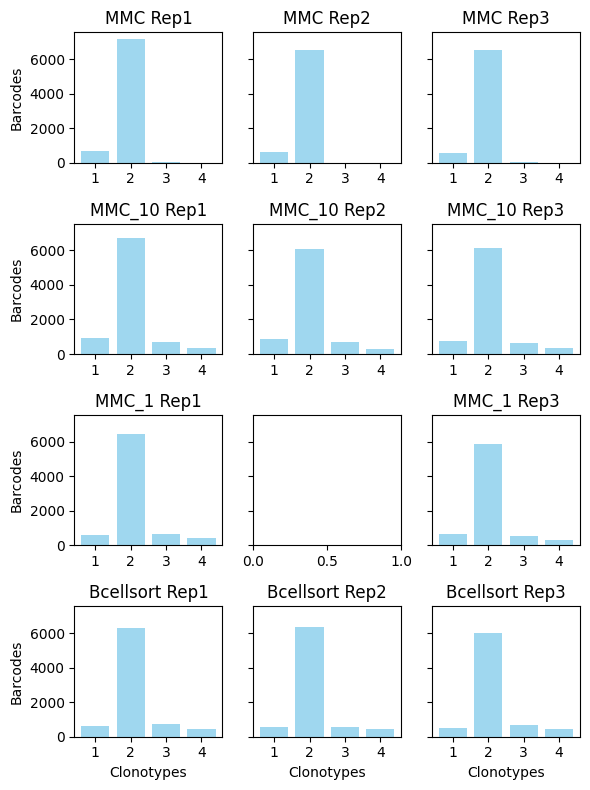

Combined plot saved to subplots_bar_plot.png


In [131]:
import pandas as pd
import matplotlib.pyplot as plt

# Input CSV file
input_csv = "/home/miguelp95/projects/BCR-SEQC/data/10x/v2_results/v2_multiplet_summary.csv"  # Replace with your file path

# Load the data
df = pd.read_csv(input_csv)

# Transpose the DataFrame and process sample names
df_transposed = df.sort_values(by='count', ascending=True).set_index('count').transpose()
df_transposed.reset_index(inplace=True)
df_transposed.rename(columns={"index": "sample"}, inplace=True)

# Extract base sample name and replicate number using the correct regex
df_transposed["base_sample"] = df_transposed["sample"].str.extract(r"5_v2_(.*?)_Rep")
df_transposed["replicate"] = df_transposed["sample"].str.extract(r"Rep(\d+)").astype(float)

# Enforce the desired base sample order
desired_order = ["MMC", "MMC_10", "MMC_1", "Bcellsort"]
df_transposed["base_sample"] = pd.Categorical(df_transposed["base_sample"], categories=desired_order, ordered=True)
df_transposed.sort_values(["base_sample", "replicate"], inplace=True)

# Get unique base samples and replicates in the desired order
base_samples = df_transposed["base_sample"].dropna().unique()
replicates = sorted(df_transposed["replicate"].dropna().unique().astype(int))

# Create a grid of subplots
fig, axes = plt.subplots(len(base_samples), len(replicates), figsize=(6, 2 * len(base_samples)), sharey=True)
if len(base_samples) == 1:  # Handle cases with one row
    axes = [axes]
if len(replicates) == 1:  # Handle cases with one column
    axes = [[ax] for ax in axes]

# Iterate over base samples and replicates to create subplots
for i, base_sample in enumerate(base_samples):
    for j, replicate in enumerate(replicates):
        ax = axes[i][j]

        # Filter data for the current base sample and replicate
        sample_name = f"5_v2_{base_sample}_Rep{replicate}"
        row = df_transposed[df_transposed["sample"] == sample_name]

        if not row.empty:
            counts = row.iloc[0, 1:-2]  # Extract counts (skip sample, base_sample, and replicate columns)
            ax.bar(range(1, 5), counts, color="skyblue", alpha=0.8)
            ax.set_xticks(range(1, 5))
            ax.set_xticklabels([1, 2, 3, 4])
            ax.set_title(f"{base_sample} Rep{replicate}")

        # Set labels for the leftmost and bottom plots
        if j == 0:
            ax.set_ylabel("Barcodes")
        if i == len(base_samples) - 1:
            ax.set_xlabel("Clonotypes")

# Adjust layout
plt.tight_layout()

# Save or display the plot
output_file = "subplots_bar_plot.png"
plt.savefig(output_file, dpi=300)
plt.show()

print(f"Combined plot saved to {output_file}")


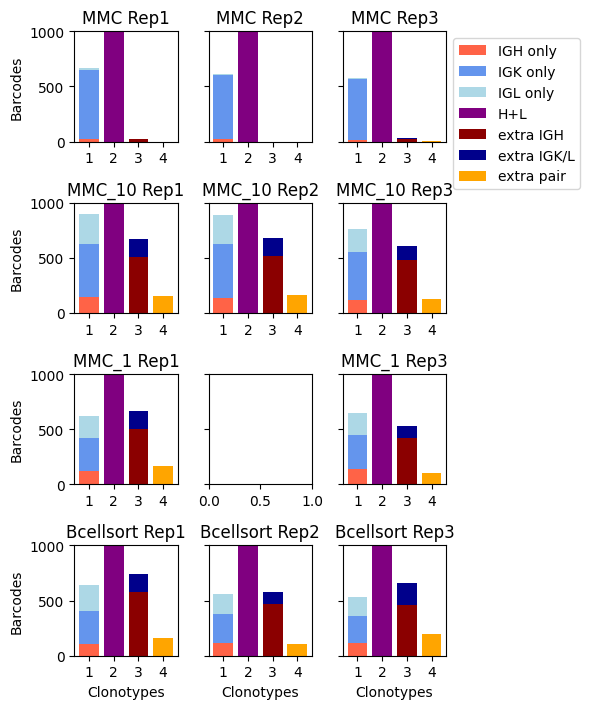

Combined plot saved to subplots_bar_plot.png


In [185]:
import pandas as pd
import matplotlib.pyplot as plt

# Input CSV file
input_csv = "/home/miguelp95/projects/BCR-SEQC/data/10x/v2_results/v2_multiplet_summary_version_2.csv"  # Replace with your file path

# Load the data
df = pd.read_csv(input_csv)

# Transpose the DataFrame and process sample names
df_transposed = df.sort_values(by="count", ascending=True).set_index("count").transpose()
df_transposed.reset_index(inplace=True)
df_transposed.rename(columns={"index": "sample"}, inplace=True)

# Extract chain type and base sample name
df_transposed["chain"] = df_transposed["sample"].str.extract(r"_(IGH|IGK|IGL)$")  # Extract chain type
df_transposed["sample"] = df_transposed["sample"].str.replace(r"_(IGH|IGK|IGL)$", "", regex=True)  # Remove chain type
df_transposed["base_sample"] = df_transposed["sample"].str.extract(r"5_v2_(.*?)_Rep")
df_transposed["replicate"] = df_transposed["sample"].str.extract(r"Rep(\d+)").astype(float)

# Enforce the desired base sample order
desired_order = ["MMC", "MMC_10", "MMC_1", "Bcellsort"]
df_transposed["base_sample"] = pd.Categorical(df_transposed["base_sample"], categories=desired_order, ordered=True)
df_transposed.sort_values(["base_sample", "replicate"], inplace=True)

# Get unique base samples and replicates in the desired order
base_samples = df_transposed["base_sample"].dropna().unique()
replicates = sorted(df_transposed["replicate"].dropna().unique().astype(int))

# Create a grid of subplots
fig, axes = plt.subplots(len(base_samples), len(replicates), figsize=(6, 2 * len(base_samples)), sharey=True)
if len(base_samples) == 1:  # Handle cases with one row
    axes = [axes]
if len(replicates) == 1:  # Handle cases with one column
    axes = [[ax] for ax in axes]

# Iterate over base samples and replicates to create subplots
for i, base_sample in enumerate(base_samples):
    for j, replicate in enumerate(replicates):
        ax = axes[i][j]

        # Filter data for the current base sample and replicate
        sample_name = f"5_v2_{base_sample}_Rep{replicate}"
        sample_data = df_transposed[df_transposed["sample"] == sample_name]

        if not sample_data.empty:
            # Retrieve counts for each chain, splitting and handling comma-separated values
            counts = {}
            for chain in ["IGH", "IGK", "IGL"]:
                chain_data = sample_data[sample_data["chain"] == chain].iloc[:, 1:-3]
                if not chain_data.empty:
                    # Extract the row values as a list of strings
                    raw_values = chain_data.iloc[0].fillna("0").tolist()
                    # Split and handle comma-separated values, converting to float
                    split_values = [float(value) if value else 0 for cell in raw_values for value in cell.split(",")]
                    counts[chain] = split_values  # Store as a list of numeric values
                else:
                    counts[chain] = [0] * 4  # Default to zeros if chain is missing

            # Plot count=1 as a stacked bar for IGH, IGK, and IGL
            ax.bar(1, counts["IGH"][0], color="tomato")
            ax.bar(1, counts["IGK"][0], bottom=counts["IGH"][0], color="cornflowerblue")
            ax.bar(1, counts["IGL"][0], bottom=counts["IGH"][0] + counts["IGK"][0], color="lightblue")

            # Plot count=2 as a single bar for IGH
            ax.bar(2, counts["IGH"][1], color="purple")

            # Plot count=3 as two stacked bars
            IGH_extra = counts["IGH"][2] if len(counts["IGH"]) > 2 else 0
            IGK_extra = counts["IGK"][2] if len(counts["IGK"]) > 2 else 0
            ax.bar(3, IGH_extra, color="darkred")
            ax.bar(3, IGK_extra, bottom=IGH_extra, color="darkblue")

            # Plot count=4 as a single bar for IGH
            IGH_pair = counts["IGH"][3] if len(counts["IGH"]) > 3 else 0
            ax.bar(4, IGH_pair, color="orange")
            
            # Set plot details
            ax.set_xticks(range(1, 5))
            ax.set_xticklabels([1, 2, 3, 4])
            ax.set_title(f"{base_sample} Rep{replicate}")

        # Set labels for the leftmost and bottom plots
        if j == 0:
            ax.set_ylabel("Barcodes")
        if i == len(base_samples) - 1:
            ax.set_xlabel("Clonotypes")

# Set a common y-axis range for shared y-axes
for ax_row in axes:
    for ax in ax_row:
        ax.set_ylim(0, 1000)

# Add a single legend to the last subplot
axes[0][-1].legend(["IGH only", "IGK only", "IGL only", "H+L", "extra IGH", "extra IGK/L", "extra pair"],
                    loc="upper left", bbox_to_anchor=(1, 1))

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.9])

# Save or display the plot
output_file = "subplots_bar_plot.png"
plt.savefig(output_file, dpi=300)
plt.show()

print(f"Combined plot saved to {output_file}")


In [165]:
print(df_transposed.head())
print("Unique samples:", df_transposed["sample"].unique())

sample_name = "5_v2_MMC_Rep1"  # Replace with an actual sample name
print(f"Sample name: {sample_name}")
row = df_transposed[df_transposed["base_sample"] == sample_name]
print(row)

count             sample    1     2     3    4 base_sample  replicate
24     5_v2_MMC_Rep1_IGK  624  7112  0,28  0,0         MMC        1.0
25     5_v2_MMC_Rep1_IGH   24  7187  28,0  0,0         MMC        1.0
26     5_v2_MMC_Rep1_IGL   18    75  0,28  0,0         MMC        1.0
27     5_v2_MMC_Rep2_IGK  583  6432   0,0  0,0         MMC        2.0
28     5_v2_MMC_Rep2_IGH   22  6520   0,0  0,0         MMC        2.0
Unique samples: ['5_v2_MMC_Rep1_IGK' '5_v2_MMC_Rep1_IGH' '5_v2_MMC_Rep1_IGL'
 '5_v2_MMC_Rep2_IGK' '5_v2_MMC_Rep2_IGH' '5_v2_MMC_Rep2_IGL'
 '5_v2_MMC_Rep3_IGK' '5_v2_MMC_Rep3_IGH' '5_v2_MMC_Rep3_IGL'
 '5_v2_MMC_10_Rep1_IGK' '5_v2_MMC_10_Rep1_IGL' '5_v2_MMC_10_Rep1_IGH'
 '5_v2_MMC_10_Rep2_IGK' '5_v2_MMC_10_Rep2_IGL' '5_v2_MMC_10_Rep2_IGH'
 '5_v2_MMC_10_Rep3_IGK' '5_v2_MMC_10_Rep3_IGL' '5_v2_MMC_10_Rep3_IGH'
 '5_v2_MMC_1_Rep1_IGK' '5_v2_MMC_1_Rep1_IGL' '5_v2_MMC_1_Rep1_IGH'
 '5_v2_MMC_1_Rep3_IGK' '5_v2_MMC_1_Rep3_IGL' '5_v2_MMC_1_Rep3_IGH'
 '5_v2_Bcellsort_Rep1_IGK' '5_v2_Bcel

In [99]:
df = df_dict['5_v2_MMC_10_Rep1']
df_f = df[df['chain']=='IGK']
#[pd.isna(df_dict['5_v2_MMC_Rep2']['cell_line'])]
#df = df[(df['chain']=='IGK') | (df['chain']=='IGL')]
#df = df[df['chain']=='IGH']
#df_dict['5_v2_MMC_Rep2'][df_dict['5_v2_MMC_Rep2']['barcode']=='AACCATGAGAAGGTTT-1']['cell_line']#.dropna().to_string(index=False)
#df_dict['5_v2_MMC_Rep2'].sort_values(by='chain',ascending=True)

# Specify the threshold
n = 1

# Find values in column 'X' that appear more than n times
frequent_values = df_f['barcode'].value_counts()[df_f['barcode'].value_counts() > n].index

# Filter the DataFrame for these values
filtered_df = df[df['barcode'].isin(frequent_values)]

#print("Filtered DataFrame:\n", filtered_df)
#filtered_df[['barcode']].value_counts()
#len(frequent_values)
#df = df[df['cell_line'].notnull()]

df['barcode'].value_counts().value_counts().to_frame().T#[df['barcode'].value_counts() == 3]

count,2,1,3,4
count,6713,900,669,374


In [93]:
df[df['barcode']=='AGCAGCCAGAATGTTG-1']

,barcode,is_cell,contig_id,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,...,cdr3,cdr3_nt,fwr4,fwr4_nt,reads,umis,raw_clonotype_id,raw_consensus_id,exact_subclonotype_id,cell_line
2111,AGCAGCCAGAATGTTG-1,True,AGCAGCCAGAATGTTG-1_contig_1,True,520,IGH,IGHV4-59,NaN,IGHJ4,IGHM,...,CARSQGVLTAIDYW,TGTGCGAGAAGTCAAGGGGTGCTGACTGCTATTGACTACTGG,GQGILVTVSS,GGCCAGGGAATCCTGGTCACCGTCTCCTCAG,901,168,clonotype10,clonotype10_consensus_1,1,MEC-1
2112,AGCAGCCAGAATGTTG-1,True,AGCAGCCAGAATGTTG-1_contig_2,True,566,IGK,IGKV4-1,NaN,IGKJ2,IGKC,...,CQQYYSIPYTF,TGTCAGCAGTATTATAGTATTCCGTACACTTTT,GQGTKLEIK,GGCCAGGGGACCAAGCTGGAGATCAAAC,3875,561,clonotype10,clonotype10_consensus_3,1,MEC-1
2113,AGCAGCCAGAATGTTG-1,True,AGCAGCCAGAATGTTG-1_contig_3,True,566,IGK,IGKV4-1,NaN,IGKJ2,IGKC,...,CQQYYSVPYTF,TGTCAGCAATATTATAGTGTTCCGTACACTTTT,GQGTKLEIK,GGCCAGGGGACCAAGCTGGAAATCAAAC,1698,321,clonotype10,clonotype10_consensus_2,1,RI-1


In [ ]:
############################################################
### Define functions for chain_type and id_by assignment ###
############################################################

def annotate_chain_info(dfi):
    labeled_df = dfi
    labeled_df['chain_type'] = labeled_df['chain'].astype(str).apply(lambda x: 'heavy' if 'H' in x else 'light')

    #labeled_df_unique = labeled_df[~pd.isna(labeled_df['cell_line'])] # drop undefined cell_line entries

    # Group the DataFrame by index
    groups = labeled_df.groupby(labeled_df.barcode)

    # Initialize an empty DataFrame to collect the results
    result_df = pd.DataFrame()


    ## Need to handle cases where, for a given barcode, there is a heavy and light clonotype, but only one of them matches a reference cell line.
    ## eg: 
    # barcode   chain_type  cell_line   id_by
    # AAAAAAA-1 heavy       DAUDI       h_only
    # AAAAAAA-1 light       None        h_only
    ## Or, when there is a disagreement between heavy and light
    ## eg: 
    # barcode   chain_type  cell_line   id_by
    # AAAAAAA-1 heavy       MEC-1       h_only
    # AAAAAAA-1 light       RI-1        h_only
    # Process each group
    for name, group in groups:
        group['id_by'] = None
        if len(set(group['cell_line'])) == 1:
            if (group['chain_type'] == 'heavy').all():
                group['id_by'] = 'h_only'
            elif (group['chain_type'] == 'light').all():
                group['id_by'] = 'l_only'
            elif set(group['chain_type']) == {'heavy', 'light'}:
                group['id_by'] = 'both'
            else:
                group['id_by'] = 'err1'  # Handle other cases if needed
        elif len(set(group['cell_line'])) > 1: 
            # Case 1: Heavy and light present, but disagree. eg:
            #
            # barcode   chain_type  cell_line   id_by
            # AAAAAAA-1 heavy       RI-1        both
            # AAAAAAA-1 light       RI-1        both
            # AAAAAAA-1 light       MEC-1       both/None
            # 
            # In such cases, heavy chain should be used to determine clonotype_cell_line. 
            if 'heavy' in set(group[(pd.notna(group['cell_line']))]['chain_type']): # If there is a heavy chain entry
                heavy_records = group[(group['chain_type'] == 'heavy') & (pd.notna(group['cell_line']))]
                # See if heavy record(s) agree on cell_line
                if len(set(heavy_records['cell_line'])) == 1:
                    heavy_cell_line = heavy_records['cell_line'].to_string(index=False)
                    congruent_records = group[group['cell_line'] == heavy_cell_line] # use heavy/light chain records with heavy chain cell_type to define set of chain_types for group
                    if set(congruent_records['chain_type']) == {'heavy', 'light'}: # If there is a heavy AND light chain entry for the heavy cell type
                        group.loc[group['cell_line'] == heavy_cell_line, 'id_by'] = 'both'
                    elif (congruent_records['chain_type'] == 'heavy').all():
                        group.loc[group['cell_line'] == heavy_cell_line, 'id_by'] = 'h_only'
                    else:
                        group['id_by'] = 'err2'
                elif len(set(heavy_records['cell_line'])) > 1: # If multiple heavy chains disagree, put 'h_disagree'
                    group.loc[group['chain_type'] == 'heavy', 'id_by'] = 'h_disagree'
                    if 'light' in set(group[(pd.notna(group['cell_line']))]['chain_type']):
                        group.loc[group['chain_type'] == 'light', 'id_by'] = 'l_only'
                else:
                    group['id_by'] = 'err4'
            elif 'light' in set(group[(pd.notna(group['cell_line']))]['chain_type']):
                light_records = group[(group['chain_type'] == 'light') & (pd.notna(group['cell_line']))]
                if len(set(light_records['cell_line'])) == 1:
                    group.loc[group['chain_type'] == 'light', 'id_by'] = 'l_only'
                else:
                    group['id_by'] = 'l_disagree'
            else:
                group['id_by'] = 'err5'
        else:
            group['id_by'] = 'err3'
        # Append the processed group to the result DataFrame
        result_df = pd.concat([result_df, group])

    return result_df

# Function to determine the value of column X
# TODO: modify to handle cases where one chain matches a cell line, but the other does not (e.g. light==>'MEC-1' and heavy==>'None', as with cell TTTGCGCTCCAAACAC-1 in MMC rep 1)
def annotate_id_by(dfi):
    # Group the DataFrame by index
    groups = dfi.groupby(dfi.barcode)

    # Initialize an empty DataFrame to collect the results
    result_df = pd.DataFrame()

    # Process each group
    for name, group in groups:
        if (group['chain_type'] == 'heavy').all():
            group['id_by'] = 'h_only'
        elif (group['chain_type'] == 'light').all():
            group['id_by'] = 'l_only'
        elif set(group['chain_type']) == {'heavy', 'light'}:
            group['id_by'] = 'both'
        else:
            group['id_by'] = 'err'  # Handle other cases if needed

        # Append the processed group to the result DataFrame
        result_df = pd.concat([result_df, group])

    return result_df

#####################################################################
### Process every df in df_dict by assigning chain_type and id_by ###
#####################################################################

dfs_ann = {} 
dfs_unique = {}

for item in df_dict.items():
    print(item[0])

    df_annotated = item[1]

    # Add 'chain_type' to dataframe
    df_annotated = annotate_chain_info(df_annotated)
    counts = pd.crosstab(df_annotated['cell_line'], df_annotated['chain_type'], margins=False)
    print(counts)

    # Add 'id_by' to dataframe
    #df_annotated = add_column_based_on_conditions(df_annotated)
    print(df_annotated.id_by.value_counts())

    dfs_ann[item[0]] = df_annotated


print(dfs_ann.keys())
print(dfs_unique.keys())
    

5_v2_Bcellsort_Rep1


KeyboardInterrupt: 

In [ ]:
for item in dfs_ann.items():
    print(item[0])

    df_annotated = item[1]

    # Generate dataframe with only unique cell barcodes
    #df_unique = df_annotated[~df_annotated.index.duplicated(keep='first')]
    #print(df_unique.id_by.value_counts())

    # Generate dataframe with only unique cell barcodes
    #df_unique = df_annotated[~((df_annotated['id_by'] == 'both') & (df_annotated['chain_type'] == 'heavy'))]
    df_unique = df_annotated[~pd.isna(df_annotated['cell_line'])].sort_values(by='chain',ascending=True) 
    df_unique = df_unique[~df_unique.barcode.duplicated(keep='first')]
    #df_unique = df_annotated[~df_annotated.cell_id.duplicated(keep='first')]

    counts = pd.crosstab(df_unique['cell_line'], df_unique['chain_type'], margins=True, dropna=False)
    print(counts)
    print(df_unique.id_by.value_counts(dropna=False))

    dfs_unique[item[0]] = df_unique

5_v2_Bcellsort_Rep1
Empty DataFrame
Columns: []
Index: []
Series([], Name: count, dtype: int64)
5_v2_Bcellsort_Rep2
Empty DataFrame
Columns: []
Index: []
Series([], Name: count, dtype: int64)
5_v2_Bcellsort_Rep3
chain_type  light  All
cell_line             
MEC-1           2    2
All             2    2
id_by
None    2
Name: count, dtype: int64
5_v2_MMC_10_Rep1
chain_type   heavy  light   All
cell_line                      
DAUDI          225     14   239
EHEB            87     16   103
JK-6           145     65   210
LB5871-LYMP     40      9    49
MEC-1          195     57   252
OCI-LY1          8      2    10
RI-1           121     26   147
WSU-DLCL        34     17    51
WSU-NHL          6      7    13
All            861    213  1074
id_by
both      827
l_only    122
None       91
h_only     34
Name: count, dtype: int64
5_v2_MMC_10_Rep2
chain_type   heavy  light  All
cell_line                     
DAUDI          206     16  222
EHEB            48     13   61
JK-6           131     7

In [ ]:
dfs_ann['5_v2_MMC_Rep3'][dfs_ann['5_v2_MMC_Rep3']['id_by']=='ACTATCTGTACCGTTA-1'][['barcode','cdr3','chain_type','reads','umis','raw_clonotype_id','cell_line','id_by']]


,barcode,cdr3,chain_type,reads,umis,raw_clonotype_id,cell_line,id_by
1386,ACTATCTGTACCGTTA-1,CARSQGVLTAIDYW,heavy,284,43,clonotype15,MEC-1,h_disagree
1387,ACTATCTGTACCGTTA-1,CQQYYSVPYTF,light,5685,1019,clonotype15,RI-1,l_only
1388,ACTATCTGTACCGTTA-1,CARKCTPERGKLGFFDYW,heavy,811,134,clonotype15,RI-1,h_disagree


In [ ]:
#dfs_ann['5_v2_MMC_Rep3'][dfs_ann['5_v2_MMC_Rep3']['id_by'] == 'h_disagree'][['barcode','cdr3','cell_line','chain_type','id_by','reads','umis']]
dfs_ann['5_v2_MMC_Rep3'][dfs_ann['5_v2_MMC_Rep3']['barcode'] == 'ACTATCTGTACCGTTA-1'][['barcode','cdr3','cell_line','chain_type','id_by','reads','umis']]

#heavy_records = group[group['chain_type'] == 'heavy']
#set(heavy_records[pd.notna(heavy_records['cell_line'])]['cell_line'])
#dfs_unique['5_v2_MMC_Rep3'][pd.isna(dfs_unique['5_v2_MMC_Rep3']['id_by'])]#['chain_type']


,barcode,cdr3,cell_line,chain_type,id_by,reads,umis
1386,ACTATCTGTACCGTTA-1,CARSQGVLTAIDYW,MEC-1,heavy,h_disagree,284,43
1387,ACTATCTGTACCGTTA-1,CQQYYSVPYTF,RI-1,light,None,5685,1019
1388,ACTATCTGTACCGTTA-1,CARKCTPERGKLGFFDYW,RI-1,heavy,h_disagree,811,134


Sample: 5_v2_MMC_10_Rep1
Total unique cells: 1074
Cell count per cell line:
cell_line
MEC-1          252
DAUDI          239
JK-6           210
RI-1           147
EHEB           103
WSU-DLCL        51
LB5871-LYMP     49
WSU-NHL         13
OCI-LY1         10
Name: count, dtype: int64
Identified by heavy or light chain:
id_by        both  h_only  l_only  All
cell_line                             
DAUDI         213      12       7  232
EHEB           85       2      10   97
JK-6          136       9      33  178
LB5871-LYMP    40       0       2   42
MEC-1         189       6      36  231
OCI-LY1         6       2       2   10
RI-1          120       1      15  136
WSU-DLCL       34       0      12   46
WSU-NHL         4       2       5   11
All           827      34     122  983


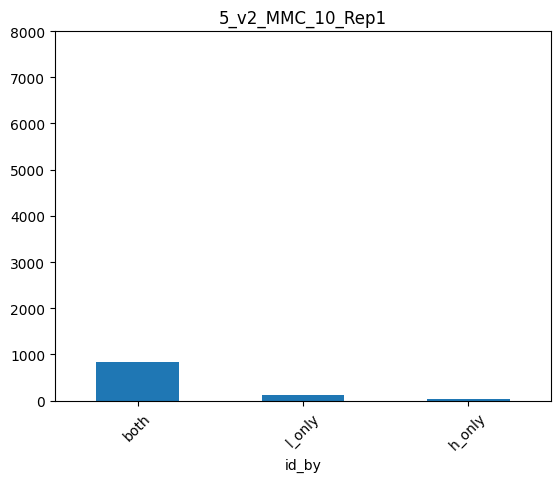

Total unique clonotypes: 7671
Clonotypes per cell line:
     cell_line  Unique_raw_clonotype_id_Count
0        DAUDI                             14
1         EHEB                             11
2         JK-6                             14
3  LB5871-LYMP                              5
4        MEC-1                             27
5      OCI-LY1                              6
6         RI-1                              6
7     WSU-DLCL                              2
8      WSU-NHL                              8
9          NaN                           7494
Cell lines per clonotype:
     raw_clonotype_id  Unique_cell_line_Count
3793    clonotype4448                       0
5054    clonotype5599                       0
5053    clonotype5598                       0
5052    clonotype5597                       0
5051    clonotype5596                       0
...               ...                     ...
234     clonotype1214                       1
218       clonotype12                       

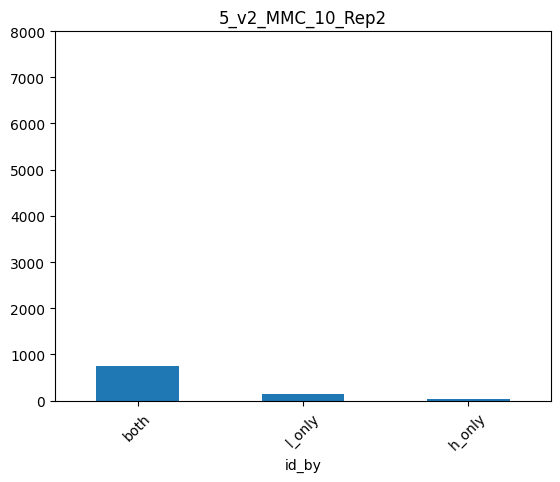

Total unique clonotypes: 6956
Clonotypes per cell line:
     cell_line  Unique_raw_clonotype_id_Count
0        DAUDI                             17
1         EHEB                             10
2         JK-6                             17
3  LB5871-LYMP                              4
4        MEC-1                             23
5      OCI-LY1                              3
6         RI-1                              6
7     WSU-DLCL                              2
8      WSU-NHL                              6
9          NaN                           6802
Cell lines per clonotype:
     raw_clonotype_id  Unique_cell_line_Count
3444    clonotype4128                       0
4583    clonotype5158                       0
4582    clonotype5157                       0
4581    clonotype5156                       0
4580    clonotype5155                       0
...               ...                     ...
3304       clonotype4                       1
5190    clonotype5712                       

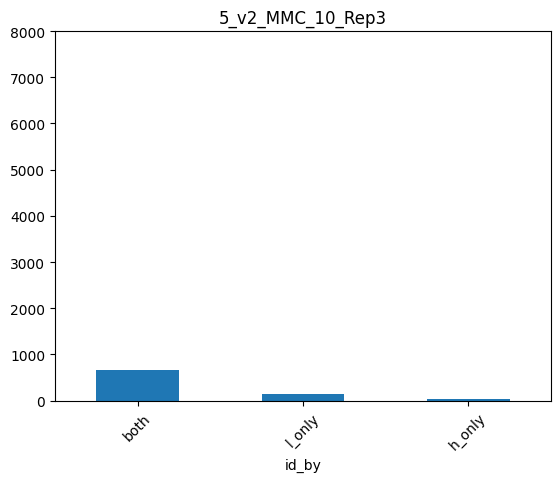

Total unique clonotypes: 6926
Clonotypes per cell line:
     cell_line  Unique_raw_clonotype_id_Count
0        DAUDI                             14
1         EHEB                             11
2         JK-6                             17
3  LB5871-LYMP                              4
4        MEC-1                             19
5      OCI-LY1                              1
6         RI-1                              4
7     WSU-DLCL                              4
8      WSU-NHL                              4
9          NaN                           6773
Cell lines per clonotype:
     raw_clonotype_id  Unique_cell_line_Count
3425    clonotype4116                       0
4554    clonotype5140                       0
4553     clonotype514                       0
4552    clonotype5139                       0
4551    clonotype5138                       0
...               ...                     ...
331       clonotype13                       1
6522       clonotype7                       

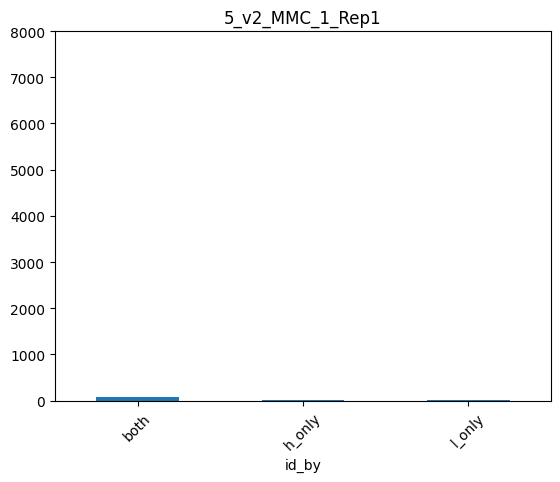

Total unique clonotypes: 7978
Clonotypes per cell line:
     cell_line  Unique_raw_clonotype_id_Count
0        DAUDI                              4
1         EHEB                              2
2         JK-6                              7
3  LB5871-LYMP                              2
4        MEC-1                             12
5      OCI-LY1                              1
6         RI-1                              6
7     WSU-DLCL                              1
8      WSU-NHL                              1
9          NaN                           7922
Cell lines per clonotype:
     raw_clonotype_id  Unique_cell_line_Count
0          clonotype1                       0
5312     clonotype579                       0
5311    clonotype5789                       0
5310    clonotype5788                       0
5309    clonotype5787                       0
...               ...                     ...
4392     clonotype496                       1
61      clonotype1053                       

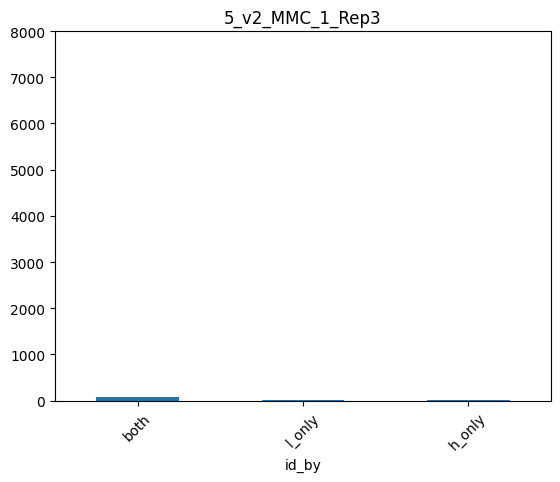

Total unique clonotypes: 7195
Clonotypes per cell line:
     cell_line  Unique_raw_clonotype_id_Count
0        DAUDI                              4
1         EHEB                              2
2         JK-6                              3
3  LB5871-LYMP                              2
4        MEC-1                              5
5      OCI-LY1                              1
6         RI-1                              4
7     WSU-DLCL                              5
8      WSU-NHL                              1
9          NaN                           7156
Cell lines per clonotype:
     raw_clonotype_id  Unique_cell_line_Count
0          clonotype1                       0
4792    clonotype5317                       0
4791    clonotype5316                       0
4790    clonotype5315                       0
4789    clonotype5314                       0
...               ...                     ...
3168    clonotype3853                       1
4740    clonotype5270                       

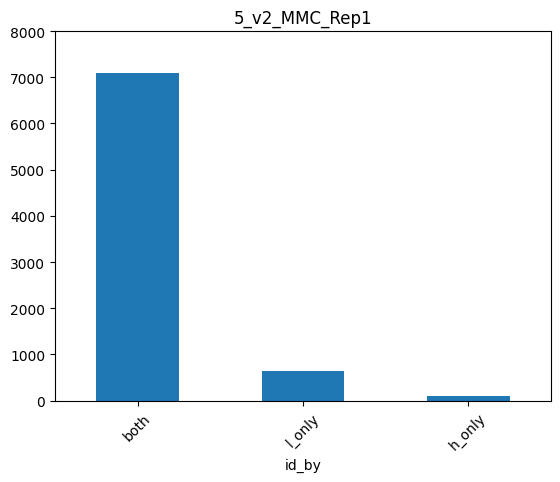

Total unique clonotypes: 46
Clonotypes per cell line:
     cell_line  Unique_raw_clonotype_id_Count
0        DAUDI                              8
1         EHEB                              4
2         JK-6                              1
3  LB5871-LYMP                              1
4        MEC-1                             20
5      OCI-LY1                              1
6         RI-1                              4
7     WSU-DLCL                              3
8      WSU-NHL                              3
9          NaN                              3
Cell lines per clonotype:
   raw_clonotype_id  Unique_cell_line_Count
9       clonotype18                       0
10      clonotype19                       0
0        clonotype1                       1
26      clonotype33                       1
27      clonotype34                       1
28      clonotype35                       1
29      clonotype36                       1
30      clonotype37                       1
31      clonotype3

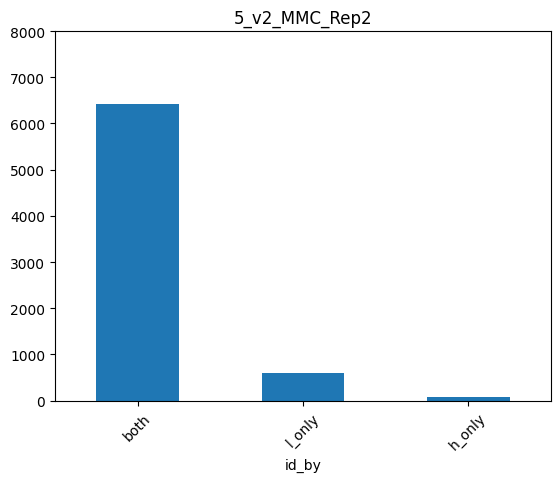

Total unique clonotypes: 37
Clonotypes per cell line:
     cell_line  Unique_raw_clonotype_id_Count
0        DAUDI                             10
1         EHEB                              4
2         JK-6                              5
3  LB5871-LYMP                              2
4        MEC-1                              8
5      OCI-LY1                              1
6         RI-1                              1
7     WSU-DLCL                              1
8      WSU-NHL                              2
9          NaN                              1
Cell lines per clonotype:
   raw_clonotype_id  Unique_cell_line_Count
0        clonotype1                       1
31       clonotype7                       1
30       clonotype6                       1
29       clonotype5                       1
28       clonotype4                       1
27      clonotype36                       1
26      clonotype35                       1
25      clonotype34                       1
24      clonotype3

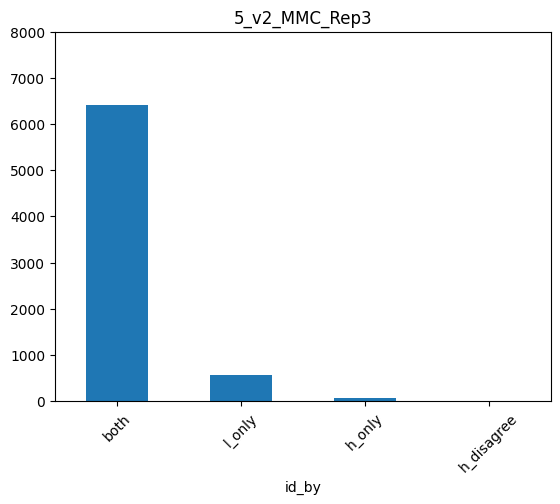

Total unique clonotypes: 33
Clonotypes per cell line:
     cell_line  Unique_raw_clonotype_id_Count
0        DAUDI                              5
1         EHEB                              5
2         JK-6                              1
3  LB5871-LYMP                              1
4        MEC-1                             14
5      OCI-LY1                              1
6         RI-1                              6
7     WSU-DLCL                              1
8      WSU-NHL                              1
9          NaN                              2
Cell lines per clonotype:
   raw_clonotype_id  Unique_cell_line_Count
9       clonotype18                       0
0        clonotype1                       1
30       clonotype7                       1
29       clonotype6                       1
28       clonotype5                       1
27       clonotype4                       1
26      clonotype33                       1
25      clonotype32                       1
24      clonotype3

In [ ]:
# Print summary for each dataframe:
#   - total unique cells: dfs_unique['SAMPLE'].shape[0]
#   - cell count per cell line: dfs_unique['5_v2_MMC_Rep1'].cell_line.value_counts(dropna=False)
#   - cell count per cell line, stratified by id_by: pd.crosstab(dfs_unique['SAMPLE']['cell_line'], dfs_unique['SAMPLE']['id_by'], margins=True, dropna=False)
#   - total unique clonotypes: dfs_unique['SAMPLE'].clone_id.value_counts().shape[0]
#   - clonotype count per cell line: unique_counts_by_column(dfs_unique['SAMPLE'],'clone_id','cell_line')
#   - total unique clonotypes, stratified by 'id_by':  (probably crosstab)

import matplotlib.pyplot as plt

def unique_counts_by_column(df, column_x, column_y):
    # Group by the unique values in column_y and count unique values in column_x for each group
    unique_counts = df.groupby(column_y, dropna = False)[column_x].nunique().reset_index()#.nunique().reset_index()
    unique_counts.columns = [column_y, f'Unique_{column_x}_Count']
    return unique_counts

#dfs_unique['5_v2_MMC_Rep1'].shape[0]
#dfs_unique['5_v2_MMC_Rep1'].cell_line.value_counts(dropna=False)
#pd.crosstab(dfs_unique['5_v2_MMC_Rep1']['clone_id'], dfs_unique['5_v2_MMC_Rep1']['id_by'], margins=True, dropna=False)
#pd.crosstab(dfs_unique['5_v2_MMC_Rep1']['cell_line'], dfs_unique['5_v2_MMC_Rep1']['clone_id'].value_counts(), margins=True, dropna=False)

for item in dfs_unique.items():
    sample = item[0]
    if 'Bcell' in sample:
        continue
    
    df = item[1]
    print(f'Sample: {sample}')

    unique_cells = df.shape[0]
    print(f'Total unique cells: {unique_cells}')

    print('Cell count per cell line:')
    print(df.cell_line.value_counts(dropna=False))

    id_by = pd.crosstab(df['cell_line'], df['id_by'], margins=True, dropna=True)
    print('Identified by heavy or light chain:')
    print(id_by)
    #plot1 = pd.crosstab(df['cell_line'], df['id_by'], margins=False, dropna=True).plot.bar(rot=45)
    #plot1.set_title(sample)
    #plot1.set_ylim(0,2000)
    #plot2 = df.id_by.value_counts().plot.bar(rot=45).set_title(sample) # plot id_by for all cells including PBMCs
    plot2 = df[~pd.isna(df['cell_line'])].id_by.value_counts().plot.bar(rot=45) #plot id_by only for non-PBMC cells
    plot2.set_title(sample)
    plot2.set_ylim(0,8000)
    plt.show()
    #plot = df['id_by'].value_counts().plot.bar(rot=0)

    unique_clones = dfs_ann[sample].raw_clonotype_id.value_counts(dropna=False)
    print(f'Total unique clonotypes: {unique_clones.shape[0]}')

    print('Clonotypes per cell line:')
    #print(unique_clones)
    print(unique_counts_by_column(dfs_ann[sample][~pd.isna(dfs_ann[sample]['id_by'])],'raw_clonotype_id','cell_line'))

    print('Cell lines per clonotype:')
    #print(dfs_ann[sample][['cell_line','raw_clonotype_id']].value_counts(dropna=False))
    print(unique_counts_by_column(dfs_ann[sample][~pd.isna(dfs_ann[sample]['id_by'])],'cell_line','raw_clonotype_id').sort_values(by='Unique_cell_line_Count'))



In [ ]:
# count UMIs per clonotype/chain

def sumClonotypeUMIs(df):
    filtered_df = df[df['id_by'].isin(['both','h_only','l_only'])] # Only consider rows where a cell_line determination was possible
    cell_counts_df = filtered_df[['raw_clonotype_id','cdr3','id_by','chain_type','cell_line']].value_counts(dropna=False)
    cell_counts_df = pd.DataFrame(cell_counts_df).reset_index()
    cell_counts_df['umis'] = None
    groups = filtered_df.groupby(filtered_df.raw_clonotype_id)

    for name,group in groups:
        heavyUMIs = group[group['chain_type']=='heavy']['umis'].sum()
        lightUMIs = group[group['chain_type']=='light']['umis'].sum()

        if (group['chain_type'] == 'heavy').all():
            cell_counts_df.loc[(cell_counts_df['raw_clonotype_id']==name) & (cell_counts_df['chain_type']=='heavy'), 'umis'] = heavyUMIs
        elif (group['chain_type'] == 'light').all():
            cell_counts_df.loc[(cell_counts_df['raw_clonotype_id']==name) & (cell_counts_df['chain_type']=='light'), 'umis'] = lightUMIs
        elif set(group['chain_type']) == {'heavy', 'light'}:
            cell_counts_df.loc[(cell_counts_df['raw_clonotype_id']==name) & (cell_counts_df['chain_type']=='heavy'), 'umis'] = heavyUMIs
            cell_counts_df.loc[(cell_counts_df['raw_clonotype_id']==name) & (cell_counts_df['chain_type']=='light'), 'umis'] = lightUMIs
    
    return cell_counts_df


def sumCellLineUMIs(df,sample_id,counts_df):
    filtered_df = df[df['id_by'].isin(['both','h_only','l_only'])] # Only consider rows where a cell_line determination was possible
    umi_counts_df = pd.DataFrame(columns=['sample_id','JK-6', 'MEC-1', 'DAUDI', 'EHEB', 'WSU-DLCL', 'RI-1',
       'LB5871-LYMP', 'OCI-LY1', 'WSU-NHL'])
    groups = filtered_df.groupby(filtered_df.cell_line)

    umi_dict = {'sample_id': sample_id}
    for name,group in groups:
        #print(name)
        umis = group['umis'].sum()
        #print(umis)
        
        umi_dict[name] = umis
    
    umi_counts_df = pd.concat([pd.Series(v, name=k) for k, v in umi_dict.items()], axis=1)

    #print(umi_counts_df)

    return pd.concat([counts_df,umi_counts_df])
        

In [ ]:
cell_line_umi_counts = pd.DataFrame()

for item in dfs_ann.items():
    sample = item[0]
    print(sample)
    dfi = item[1]

    # Make a dataframe like this:
    #
    # clone_id    junction_aa                           cell_line
    # clonotype1  CARWGSPSSPGIAAADDAFDIW;CMQALQTPLTF    JK-6
    #
    # where junction_aa is heavy;light
    #
    # value_counts() does this beautifully!

    #clonotype_cell_counts = dfi[dfi['id_by'].isin(['both','h_only','l_only'])][['raw_clonotype_id','cdr3','id_by','chain_type','cell_line']].value_counts(dropna=False)
    #print(clonotype_cell_counts)

    clonotype_umi_counts = sumClonotypeUMIs(dfi)
    print(clonotype_umi_counts)
    clonotype_umi_counts.to_csv('/home/miguelp95/projects/BCR-SEQC/' + sample + '_clonotypes_umis.csv')

    cell_line_umi_counts = sumCellLineUMIs(dfi,sample,cell_line_umi_counts)

print(cell_line_umi_counts.set_index('sample_id').T)
    

5_v2_Bcellsort_Rep1
      raw_clonotype_id                  cdr3   id_by chain_type  cell_line  \
0           clonotype1         CAAWDDSLSGWVF    both      light        NaN   
1           clonotype1  CAKDRERAPLNYYYYGMDVW    both      heavy        NaN   
2           clonotype2         CAAWDDSLSGWVF  l_only      light        NaN   
3           clonotype3           CQQSYSVLWTF  l_only      light        NaN   
4           clonotype4           CMQALQTPLTF    both      light        NaN   
...                ...                   ...     ...        ...        ...   
17102    clonotype3373          CQYRSDWPPFTF    both      light        NaN   
17103    clonotype3373     CVRDVSQGYGLFYFDSW    both      heavy        NaN   
17104    clonotype3374     CARARDFWKTYYFFDYW    both      heavy        NaN   
17105    clonotype3374          CQQYNNWPPLTF    both      light        NaN   
17106     clonotype999         CTTDPLRGDHRGW    both      heavy        NaN   

       count  umis  
0         29   378  
1

In [ ]:
cell_line_umi_counts.set_index('sample_id').T.to_csv('/home/miguelp95/projects/BCR-SEQC/cell_line_umis.csv')